# <font color=blue>**Telecom Churn Prediction**</font> 


### <font color=blue>**Problem Statement**</font>
As the new customer acquisition costs for telecom companies typically is 5-10 times more than the cost to retain their existing customers, customer retention is of utmost importance. The objective of this project is to analyze customer level data of a leading telecom firm to build predictive models to identify customers at high risk of churn and identify the main indicators of churn

Keys facts of the Customer data 
1. The project is based on Indian and Southeast Asian market where mostly prepaid payment model is prevelant
2. In this project we will use the usage-based chrun definition i.e. customers who have not done any usage either incoming or outgoing in terms of calls, internet etc. over a period of time
3. We focus only the High Value customers, as typically 80% of the revenue comes from top 20% of the customers
4. The dataset spans data of four consecutive months between June - September. The objective is to predict the churn in the last month using the data from the first three months
5. There are typically three phases of a customer lifecycle - (a) Good Phase where the customer is happy with services. We have assumed month 6 and 7 as Good Phase period here.(b) Action Phase where customer experience starts to sore. We have assumed the 3rd month i.e. month 8 here for this (c) Churn Phase where the customer is said to have churned. This is equivalent to the month 9 here

### <font color=blue>**Overall Approach Followed**</font>
1. Reading and Understanding Data 
    - Understanding the number of rows and columns, data types, column names etc.
2. Identifying High Value Customers
    - Those who recharged with an amount more than or equal to 70th percentile of the average recharge amount in the first two months
    - Imputing missing values in columns required to calculate High Value Customers
    - Filtering around 29.9K customer records
3. Data Preparation
    - Data Imbalance: Dropping columns that are highly unbalanced i.e. all values in the column are the same
    - Treating Date Columns: Extracting the number of days i.e. difference between the last date of the month and day provided
    - Imputing missing values randomly as per the distribution of the column to keep the distribution unchanged or with 0 as applicable
    - Categorical Variables: Treating categorical variables by using dummy variables
4. Tagging Churners
    - Create a target variable based on provided criteria
    - Drop all the other columns related only to month 9
5. Splitting into train-test data sets
6. Scaling on Train data set
7. Dividing train data set to y_train and x_train
8. Performing PCA
    - Identifying key components that capture the maximum variance
9. Model Building exercise. Using the following algorithms
    - Logistic Regression
    - Decision Tree
    - Random Forest
10. Hyperparameter Tuning
    - Identify best scores for different hyperparameters for each of the alogrithms above
    - Build models using the best scores derived
11. Making Predictions using the Final Model
    - Predict on the test data using the Final Model
12. Model Evaluation Metrics Calculation
    - Checking the Confusion Matrix
    - Checking key metrics applicable here - Sensitivity and Accuracy
13. Compare the results from all the models used and select the best model
14. Build a separate model to identify the attributes that are key predictors
15. Visualize the trends of the key predictors identified across the 3 months (i.e. month 6,7 and 8)
16. Final Conclusion 
    - Derive inferences
17. Make Recommendations
    - Recommendations to Business and the possible strategies to adopt

In [99]:
import pandas as pd
import numpy as np
from datetime import datetime
import random
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import IncrementalPCA

In [100]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics

In [423]:
# Importing modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [101]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [102]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  

In [103]:
tchurn_df = pd.read_csv("telecom_churn_data.csv")

In [104]:
tchurn_df.shape

(99999, 226)

In [105]:
tchurn_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               int64
circle_id                   int64
loc_og_t2o_mou              float64
std_og_t2o_mou              float64
loc_ic_t2o_mou              float64
last_date_of_month_6        object
last_date_of_month_7        object
last_date_of_month_8        object
last_date_of_month_9        object
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
arpu_9                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
onnet_mou_9                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
offnet_mou_9                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_ic_mou_9               float6

#### Mostly all the date columns are only of 'object' type
#### All others are either int64 or float64

In [106]:
round(tchurn_df.isnull().sum()*100/len(tchurn_df),2)

mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               1.02
std_og_t2o_mou               1.02
loc_ic_t2o_mou               1.02
last_date_of_month_6         0.00
last_date_of_month_7         0.60
last_date_of_month_8         1.10
last_date_of_month_9         1.66
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  3.94
onnet_mou_7                  3.86
onnet_mou_8                  5.38
onnet_mou_9                  7.75
offnet_mou_6                 3.94
offnet_mou_7                 3.86
offnet_mou_8                 5.38
offnet_mou_9                 7.75
roam_ic_mou_6                3.94
roam_ic_mou_7                3.86
roam_ic_mou_8                5.38
roam_ic_mou_9                7.75
roam_og_mou_6                3.94
roam_og_mou_7                3.86
roam_og_mou_8                5.38
roam_og_mou_9                7.75
loc_og_t2t_mou

#### Need to calculate the churn for only High Value Customers therefore, calculating High Value Customers

#### The key columns to calculate High Value Customers have lots of missing values i.e. ~ > 70%
#### Imputing them with 0

In [107]:
tchurn_df['total_rech_data_6'].fillna(0,inplace=True)
tchurn_df['av_rech_amt_data_6'].fillna(0,inplace=True)
tchurn_df['total_rech_data_7'].fillna(0,inplace=True)
tchurn_df['av_rech_amt_data_7'].fillna(0,inplace=True)

In [108]:
tchurn_df['total_data_rech_6'] = tchurn_df['total_rech_data_6'] * tchurn_df['av_rech_amt_data_6']
tchurn_df['total_recharge_amount_6'] = tchurn_df['total_rech_amt_6'] + tchurn_df['total_data_rech_6']

In [109]:
tchurn_df['total_data_rech_7'] = tchurn_df['total_rech_data_7'] * tchurn_df['av_rech_amt_data_7']
tchurn_df['total_recharge_amount_7'] = tchurn_df['total_rech_amt_7'] + tchurn_df['total_data_rech_7']

In [110]:
tchurn_df['average_recharge_amount'] = (tchurn_df['total_recharge_amount_6'] + tchurn_df['total_recharge_amount_7'])/2

In [111]:
len(tchurn_df.loc[tchurn_df['average_recharge_amount'].isnull()])

0

In [112]:
tchurn_df['average_recharge_amount'].quantile(0.7)

478.0

In [113]:
tchurn_df['average_recharge_amount'].describe()

count    99999.000000
mean       485.328068
std        869.423594
min          0.000000
25%        128.000000
50%        275.000000
75%        553.000000
max      61236.000000
Name: average_recharge_amount, dtype: float64

In [114]:
len(tchurn_df.loc[(tchurn_df['average_recharge_amount'] > tchurn_df['average_recharge_amount'].quantile(0.7))])

29953

#### There are around 29K records corresponding to High Value customers

In [115]:
# filter them out
tchurn_hv_df = tchurn_df.loc[(tchurn_df['average_recharge_amount'] > tchurn_df['average_recharge_amount'].quantile(0.7))]

In [116]:
tchurn_hv_df.shape

(29953, 231)

In [117]:
tchurn_hv_df.nunique()

mobile_number               29953
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
last_date_of_month_9            1
arpu_6                      29029
arpu_7                      29040
arpu_8                      28035
arpu_9                      26981
onnet_mou_6                 16872
onnet_mou_7                 16973
onnet_mou_8                 15854
onnet_mou_9                 15063
offnet_mou_6                21198
offnet_mou_7                21233
offnet_mou_8                20140
offnet_mou_9                19130
roam_ic_mou_6                4045
roam_ic_mou_7                3381
roam_ic_mou_8                3431
roam_ic_mou_9                3132
roam_og_mou_6                4742
roam_og_mou_7                3988
roam_og_mou_8                3996
roam_og_mou_9                3663
loc_og_t2t_mou

In [118]:
print(tchurn_hv_df['circle_id'].value_counts())
print(tchurn_hv_df['loc_og_t2o_mou'].value_counts())
print(tchurn_hv_df['std_og_t2o_mou'].value_counts())
print(tchurn_hv_df['loc_ic_t2o_mou'].value_counts())
print(tchurn_hv_df['last_date_of_month_6'].value_counts())
print(tchurn_hv_df['last_date_of_month_7'].value_counts())
print(tchurn_hv_df['last_date_of_month_8'].value_counts())
print(tchurn_hv_df['std_og_t2c_mou_6'].value_counts())
print(tchurn_hv_df['std_og_t2c_mou_7'].value_counts())
print(tchurn_hv_df['std_og_t2c_mou_8'].value_counts())
print(tchurn_hv_df['std_og_t2c_mou_9'].value_counts())
print(tchurn_hv_df['std_ic_t2o_mou_6'].value_counts())
print(tchurn_hv_df['std_ic_t2o_mou_7'].value_counts())
print(tchurn_hv_df['std_ic_t2o_mou_8'].value_counts())
print(tchurn_hv_df['std_ic_t2o_mou_9'].value_counts())

109    29953
Name: circle_id, dtype: int64
0.0    29730
Name: loc_og_t2o_mou, dtype: int64
0.0    29730
Name: std_og_t2o_mou, dtype: int64
0.0    29730
Name: loc_ic_t2o_mou, dtype: int64
6/30/2014    29953
Name: last_date_of_month_6, dtype: int64
7/31/2014    29926
Name: last_date_of_month_7, dtype: int64
8/31/2014    29788
Name: last_date_of_month_8, dtype: int64
0.0    29411
Name: std_og_t2c_mou_6, dtype: int64
0.0    29417
Name: std_og_t2c_mou_7, dtype: int64
0.0    28781
Name: std_og_t2c_mou_8, dtype: int64
0.0    28055
Name: std_og_t2c_mou_9, dtype: int64
0.0    29411
Name: std_ic_t2o_mou_6, dtype: int64
0.0    29417
Name: std_ic_t2o_mou_7, dtype: int64
0.0    28781
Name: std_ic_t2o_mou_8, dtype: int64
0.0    28055
Name: std_ic_t2o_mou_9, dtype: int64


### All the above columns are not needed as they only one value for all records

In [119]:
tchurn_hv_df = tchurn_hv_df.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou',
                           'loc_ic_t2o_mou','last_date_of_month_6','last_date_of_month_7',
                           'last_date_of_month_8','std_og_t2c_mou_6','std_og_t2c_mou_7',
                           'std_og_t2c_mou_8','std_og_t2c_mou_9','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8',
                           'std_ic_t2o_mou_9','last_date_of_month_9'],axis=1)

In [120]:
tchurn_hv_df.shape

(29953, 215)

In [121]:
tchurn_hv_df.nunique()

mobile_number               29953
arpu_6                      29029
arpu_7                      29040
arpu_8                      28035
arpu_9                      26981
onnet_mou_6                 16872
onnet_mou_7                 16973
onnet_mou_8                 15854
onnet_mou_9                 15063
offnet_mou_6                21198
offnet_mou_7                21233
offnet_mou_8                20140
offnet_mou_9                19130
roam_ic_mou_6                4045
roam_ic_mou_7                3381
roam_ic_mou_8                3431
roam_ic_mou_9                3132
roam_og_mou_6                4742
roam_og_mou_7                3988
roam_og_mou_8                3996
roam_og_mou_9                3663
loc_og_t2t_mou_6            10416
loc_og_t2t_mou_7            10388
loc_og_t2t_mou_8            10056
loc_og_t2t_mou_9             9690
loc_og_t2m_mou_6            15607
loc_og_t2m_mou_7            15659
loc_og_t2m_mou_8            15118
loc_og_t2m_mou_9            14584
loc_og_t2f_mou

In [122]:
tchurn_hv_df.isnull().sum()

mobile_number                   0
arpu_6                          0
arpu_7                          0
arpu_8                          0
arpu_9                          0
onnet_mou_6                   542
onnet_mou_7                   536
onnet_mou_8                  1172
onnet_mou_9                  1898
offnet_mou_6                  542
offnet_mou_7                  536
offnet_mou_8                 1172
offnet_mou_9                 1898
roam_ic_mou_6                 542
roam_ic_mou_7                 536
roam_ic_mou_8                1172
roam_ic_mou_9                1898
roam_og_mou_6                 542
roam_og_mou_7                 536
roam_og_mou_8                1172
roam_og_mou_9                1898
loc_og_t2t_mou_6              542
loc_og_t2t_mou_7              536
loc_og_t2t_mou_8             1172
loc_og_t2t_mou_9             1898
loc_og_t2m_mou_6              542
loc_og_t2m_mou_7              536
loc_og_t2m_mou_8             1172
loc_og_t2m_mou_9             1898
loc_og_t2f_mou

#### There is an interesting pattern here that is described below
- The number of missing values across columns for the same month are same
- That is the following columns for month 6 all have the same number of missing attributes
> onnet_mou_6, offnet_mou_6, roam_ic_mou_6, roam_og_mou_6, loc_og_t2t_mou_6, loc_og_t2m_mou_6, loc_og_t2f_mou_6,loc_og_t2c_mou_6, loc_og_mou_6, std_og_t2t_mou_6, std_og_t2m_mou_6, std_og_t2f_mou_6,std_og_t2c_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6, og_others_6,loc_ic_t2t_mou_6, loc_ic_t2m_mou_6,
loc_ic_t2f_mou_6, loc_ic_mou_6, std_ic_t2t_mou_6, std_ic_t2m_mou_6, std_ic_t2f_mou_6, std_ic_t2o_mou_6, std_ic_mou_6,
spl_ic_mou_6, isd_ic_mou_6, ic_others_6
- Similar is the case with columns related to other months as well
- Therefore, we can try dropping this number of rows together across all these related columns

In [123]:
tchurn_hv_df.drop(tchurn_hv_df.loc[tchurn_hv_df['onnet_mou_6'].isnull()].index,inplace=True)
tchurn_hv_df.drop(tchurn_hv_df.loc[tchurn_hv_df['onnet_mou_7'].isnull()].index,inplace=True)
tchurn_hv_df.drop(tchurn_hv_df.loc[tchurn_hv_df['onnet_mou_8'].isnull()].index,inplace=True)
tchurn_hv_df.drop(tchurn_hv_df.loc[tchurn_hv_df['onnet_mou_9'].isnull()].index,inplace=True)

In [124]:
tchurn_hv_df.shape

(27587, 215)

In [125]:
tchurn_hv_df.isnull().sum()

mobile_number                   0
arpu_6                          0
arpu_7                          0
arpu_8                          0
arpu_9                          0
onnet_mou_6                     0
onnet_mou_7                     0
onnet_mou_8                     0
onnet_mou_9                     0
offnet_mou_6                    0
offnet_mou_7                    0
offnet_mou_8                    0
offnet_mou_9                    0
roam_ic_mou_6                   0
roam_ic_mou_7                   0
roam_ic_mou_8                   0
roam_ic_mou_9                   0
roam_og_mou_6                   0
roam_og_mou_7                   0
roam_og_mou_8                   0
roam_og_mou_9                   0
loc_og_t2t_mou_6                0
loc_og_t2t_mou_7                0
loc_og_t2t_mou_8                0
loc_og_t2t_mou_9                0
loc_og_t2m_mou_6                0
loc_og_t2m_mou_7                0
loc_og_t2m_mou_8                0
loc_og_t2m_mou_9                0
loc_og_t2f_mou

In [126]:
print(tchurn_hv_df['date_of_last_rech_6'].value_counts())
print(tchurn_hv_df['date_of_last_rech_7'].value_counts())
print(tchurn_hv_df['date_of_last_rech_8'].value_counts())
print(tchurn_hv_df['date_of_last_rech_9'].value_counts())

6/30/2014    7840
6/29/2014    4979
6/28/2014    3421
6/27/2014    2922
6/26/2014    1700
6/25/2014    1202
6/24/2014     952
6/23/2014     655
6/21/2014     557
6/14/2014     485
6/22/2014     478
6/17/2014     368
6/20/2014     362
6/19/2014     354
6/18/2014     347
6/16/2014     182
6/12/2014     180
6/13/2014     171
6/15/2014     120
6/11/2014      65
6/8/2014       43
6/7/2014       36
6/10/2014      30
6/9/2014       23
6/5/2014       23
6/3/2014       16
6/6/2014       15
6/4/2014       13
6/2/2014       12
6/1/2014        6
Name: date_of_last_rech_6, dtype: int64
7/31/2014    7235
7/30/2014    4991
7/29/2014    3297
7/28/2014    2648
7/25/2014    1724
7/27/2014    1633
7/26/2014    1460
7/24/2014     845
7/22/2014     585
7/23/2014     501
7/16/2014     385
7/15/2014     385
7/20/2014     368
7/21/2014     353
7/19/2014     323
7/17/2014     233
7/18/2014     225
7/14/2014      54
7/9/2014       51
7/12/2014      46
7/10/2014      46
7/13/2014      44
7/11/2014      38
7/7/20

#### All the dates have 2014 as the year
#### These different days within the month to which the column corresponds to
#### We can convert the date to days by subtracting it from the last date of that particular month

In [127]:
date_format = "%m/%d/%Y"
b = datetime.strptime('6/30/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_6'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_6'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_6'] = date_list

In [128]:
date_format = "%m/%d/%Y"
b = datetime.strptime('7/31/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_7'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_7'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_7'] = date_list

In [129]:
date_format = "%m/%d/%Y"
b = datetime.strptime('8/31/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_8'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_8'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_8'] = date_list

In [130]:
date_format = "%m/%d/%Y"
b = datetime.strptime('9/30/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_9'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_9'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_9'] = date_list

In [131]:
unique_val = tchurn_hv_df['days_of_last_rech_6'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_6"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_6"] == -1 else row["days_of_last_rech_6"],axis=1)

unique_val = tchurn_hv_df['days_of_last_rech_7'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_7"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_7"] == -1 else row["days_of_last_rech_7"],axis=1)

unique_val = tchurn_hv_df['days_of_last_rech_8'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_8"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_8"] == -1 else row["days_of_last_rech_8"],axis=1)

unique_val = tchurn_hv_df['days_of_last_rech_9'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_9"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_9"] == -1 else row["days_of_last_rech_9"],axis=1)

In [132]:
# Dropping original columns now as we have derived the required days
tchurn_hv_df.drop(['date_of_last_rech_6','date_of_last_rech_7',
               'date_of_last_rech_8','date_of_last_rech_9'],axis=1,inplace=True)

In [133]:
round(tchurn_hv_df.isnull().sum()*100/len(tchurn_hv_df),2)

mobile_number                0.00
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  0.00
onnet_mou_7                  0.00
onnet_mou_8                  0.00
onnet_mou_9                  0.00
offnet_mou_6                 0.00
offnet_mou_7                 0.00
offnet_mou_8                 0.00
offnet_mou_9                 0.00
roam_ic_mou_6                0.00
roam_ic_mou_7                0.00
roam_ic_mou_8                0.00
roam_ic_mou_9                0.00
roam_og_mou_6                0.00
roam_og_mou_7                0.00
roam_og_mou_8                0.00
roam_og_mou_9                0.00
loc_og_t2t_mou_6             0.00
loc_og_t2t_mou_7             0.00
loc_og_t2t_mou_8             0.00
loc_og_t2t_mou_9             0.00
loc_og_t2m_mou_6             0.00
loc_og_t2m_mou_7             0.00
loc_og_t2m_mou_8             0.00
loc_og_t2m_mou_9             0.00
loc_og_t2f_mou

#### All of the remaining columns have considerable number of missing value >40% of values missing therefore have to treat them individually

In [134]:
tchurn_hv_df.loc[~tchurn_hv_df['fb_user_6'].isnull()]['fb_user_6'].unique()

array([1., 0.])

In [135]:
unique_val = tchurn_hv_df.loc[~tchurn_hv_df['fb_user_6'].isnull()]['fb_user_6'].unique()
tchurn_hv_df['fb_user_6'].fillna(-1,inplace=True)
tchurn_hv_df["fb_user_6"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["fb_user_6"] == -1 else row["fb_user_6"],axis=1)

In [136]:
tchurn_hv_df['fb_user_6'].value_counts()

1.0    20358
0.0     7229
Name: fb_user_6, dtype: int64

In [137]:
unique_val = tchurn_hv_df.loc[~tchurn_hv_df['fb_user_7'].isnull()]['fb_user_7'].unique()
tchurn_hv_df['fb_user_7'].fillna(-1,inplace=True)
tchurn_hv_df["fb_user_7"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["fb_user_7"] == -1 else row["fb_user_7"],axis=1)

unique_val = tchurn_hv_df.loc[~tchurn_hv_df['fb_user_8'].isnull()]['fb_user_8'].unique()
tchurn_hv_df['fb_user_8'].fillna(-1,inplace=True)
tchurn_hv_df["fb_user_8"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["fb_user_8"] == -1 else row["fb_user_8"],axis=1)

unique_val = tchurn_hv_df.loc[~tchurn_hv_df['fb_user_9'].isnull()]['fb_user_9'].unique()
tchurn_hv_df['fb_user_9'].fillna(-1,inplace=True)
tchurn_hv_df["fb_user_9"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["fb_user_9"] == -1 else row["fb_user_9"],axis=1)

In [138]:
# Treating other total data recharge columns as we did for months 6 and 7
tchurn_hv_df['total_rech_data_8'].fillna(0,inplace=True)
tchurn_hv_df['av_rech_amt_data_8'].fillna(0,inplace=True)
tchurn_hv_df['total_rech_data_9'].fillna(0,inplace=True)
tchurn_hv_df['av_rech_amt_data_9'].fillna(0,inplace=True)

In [139]:
# Also, treating other total, maximum, count of recharge columns as we did above i.e. fill with 0
tchurn_hv_df['max_rech_data_6'].fillna(0,inplace=True)
tchurn_hv_df['max_rech_data_7'].fillna(0,inplace=True)
tchurn_hv_df['max_rech_data_8'].fillna(0,inplace=True)
tchurn_hv_df['max_rech_data_9'].fillna(0,inplace=True)

tchurn_hv_df['count_rech_2g_6'].fillna(0,inplace=True)
tchurn_hv_df['count_rech_2g_7'].fillna(0,inplace=True)
tchurn_hv_df['count_rech_2g_8'].fillna(0,inplace=True)
tchurn_hv_df['count_rech_2g_9'].fillna(0,inplace=True)

tchurn_hv_df['count_rech_3g_6'].fillna(0,inplace=True)
tchurn_hv_df['count_rech_3g_7'].fillna(0,inplace=True)
tchurn_hv_df['count_rech_3g_8'].fillna(0,inplace=True)
tchurn_hv_df['count_rech_3g_9'].fillna(0,inplace=True)

In [140]:
tchurn_hv_df['arpu_3g_6'].fillna(0,inplace=True)
tchurn_hv_df['arpu_3g_7'].fillna(0,inplace=True)
tchurn_hv_df['arpu_3g_8'].fillna(0,inplace=True)
tchurn_hv_df['arpu_3g_9'].fillna(0,inplace=True)

tchurn_hv_df['arpu_2g_6'].fillna(0,inplace=True)
tchurn_hv_df['arpu_2g_7'].fillna(0,inplace=True)
tchurn_hv_df['arpu_2g_8'].fillna(0,inplace=True)
tchurn_hv_df['arpu_2g_9'].fillna(0,inplace=True)

In [141]:
print(tchurn_hv_df['night_pck_user_6'].value_counts())
print(tchurn_hv_df['night_pck_user_7'].value_counts())
print(tchurn_hv_df['night_pck_user_8'].value_counts())
print(tchurn_hv_df['night_pck_user_9'].value_counts())

0.0    14958
1.0      369
Name: night_pck_user_6, dtype: int64
0.0    15400
1.0      356
Name: night_pck_user_7, dtype: int64
0.0    14820
1.0      331
Name: night_pck_user_8, dtype: int64
0.0    14411
1.0      265
Name: night_pck_user_9, dtype: int64


In [142]:
unique_val = tchurn_hv_df.loc[~tchurn_hv_df['night_pck_user_6'].isnull()]['night_pck_user_6'].unique()
tchurn_hv_df['night_pck_user_6'].fillna(-1,inplace=True)
tchurn_hv_df["night_pck_user_6"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["night_pck_user_6"] == -1 else row["night_pck_user_6"],axis=1)

unique_val = tchurn_hv_df.loc[~tchurn_hv_df['night_pck_user_7'].isnull()]['night_pck_user_7'].unique()
tchurn_hv_df['night_pck_user_7'].fillna(-1,inplace=True)
tchurn_hv_df["night_pck_user_7"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["night_pck_user_7"] == -1 else row["night_pck_user_7"],axis=1)

unique_val = tchurn_hv_df.loc[~tchurn_hv_df['night_pck_user_8'].isnull()]['night_pck_user_8'].unique()
tchurn_hv_df['night_pck_user_8'].fillna(-1,inplace=True)
tchurn_hv_df["night_pck_user_8"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["night_pck_user_8"] == -1 else row["night_pck_user_8"],axis=1)

unique_val = tchurn_hv_df.loc[~tchurn_hv_df['night_pck_user_9'].isnull()]['night_pck_user_9'].unique()
tchurn_hv_df['night_pck_user_9'].fillna(-1,inplace=True)
tchurn_hv_df["night_pck_user_9"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["night_pck_user_9"] == -1 else row["night_pck_user_9"],axis=1)

In [143]:
# Dropping additional columns that were created for computation of High Value customers
tchurn_hv_df.drop(['total_data_rech_6','total_recharge_amount_6',
                  'total_data_rech_7','total_recharge_amount_7','average_recharge_amount'],axis=1,inplace=True)

In [144]:
round(tchurn_hv_df.isnull().sum()*100/len(tchurn_hv_df),2)

mobile_number                0.00
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  0.00
onnet_mou_7                  0.00
onnet_mou_8                  0.00
onnet_mou_9                  0.00
offnet_mou_6                 0.00
offnet_mou_7                 0.00
offnet_mou_8                 0.00
offnet_mou_9                 0.00
roam_ic_mou_6                0.00
roam_ic_mou_7                0.00
roam_ic_mou_8                0.00
roam_ic_mou_9                0.00
roam_og_mou_6                0.00
roam_og_mou_7                0.00
roam_og_mou_8                0.00
roam_og_mou_9                0.00
loc_og_t2t_mou_6             0.00
loc_og_t2t_mou_7             0.00
loc_og_t2t_mou_8             0.00
loc_og_t2t_mou_9             0.00
loc_og_t2m_mou_6             0.00
loc_og_t2m_mou_7             0.00
loc_og_t2m_mou_8             0.00
loc_og_t2m_mou_9             0.00
loc_og_t2f_mou

In [145]:
date_format = "%m/%d/%Y"
b = datetime.strptime('6/30/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_data_6'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_data_6'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_data_6'] = date_list

b = datetime.strptime('7/31/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_data_7'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_data_7'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_data_7'] = date_list

b = datetime.strptime('8/31/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_data_8'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_data_8'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_data_8'] = date_list

b = datetime.strptime('9/30/2014', date_format)
date_list = []
for i in range(len(tchurn_hv_df)):
    if (pd.isna(tchurn_hv_df['date_of_last_rech_data_9'].iloc[i])):
        date_list.append(-1)
    else:
        a = datetime.strptime(tchurn_hv_df['date_of_last_rech_data_9'].iloc[i], date_format)
        delta = b - a
        date_list.append(delta.days)
tchurn_hv_df['days_of_last_rech_data_9'] = date_list

In [146]:
unique_val = tchurn_hv_df['days_of_last_rech_data_6'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_data_6"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_data_6"] == -1 else row["days_of_last_rech_data_6"],axis=1)

unique_val = tchurn_hv_df['days_of_last_rech_data_7'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_data_7"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_data_7"] == -1 else row["days_of_last_rech_data_7"],axis=1)

unique_val = tchurn_hv_df['days_of_last_rech_data_8'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_data_8"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_data_8"] == -1 else row["days_of_last_rech_data_8"],axis=1)

unique_val = tchurn_hv_df['days_of_last_rech_data_9'].unique()
unique_val = np.delete(unique_val,[-1])
tchurn_hv_df["days_of_last_rech_data_9"] = tchurn_hv_df.apply(lambda row: random.choice(unique_val) if row["days_of_last_rech_data_9"] == -1 else row["days_of_last_rech_data_9"],axis=1)

In [147]:
# Dropping original columns
tchurn_hv_df.drop(['date_of_last_rech_data_6',
                  'date_of_last_rech_data_7',
                  'date_of_last_rech_data_8',
                  'date_of_last_rech_data_9'],axis=1,inplace=True)

In [148]:
round(tchurn_hv_df.isnull().sum()*100/len(tchurn_hv_df),2)

mobile_number               0.0
arpu_6                      0.0
arpu_7                      0.0
arpu_8                      0.0
arpu_9                      0.0
onnet_mou_6                 0.0
onnet_mou_7                 0.0
onnet_mou_8                 0.0
onnet_mou_9                 0.0
offnet_mou_6                0.0
offnet_mou_7                0.0
offnet_mou_8                0.0
offnet_mou_9                0.0
roam_ic_mou_6               0.0
roam_ic_mou_7               0.0
roam_ic_mou_8               0.0
roam_ic_mou_9               0.0
roam_og_mou_6               0.0
roam_og_mou_7               0.0
roam_og_mou_8               0.0
roam_og_mou_9               0.0
loc_og_t2t_mou_6            0.0
loc_og_t2t_mou_7            0.0
loc_og_t2t_mou_8            0.0
loc_og_t2t_mou_9            0.0
loc_og_t2m_mou_6            0.0
loc_og_t2m_mou_7            0.0
loc_og_t2m_mou_8            0.0
loc_og_t2m_mou_9            0.0
loc_og_t2f_mou_6            0.0
loc_og_t2f_mou_7            0.0
loc_og_t

#### Now we dont have any NULL Values

In [149]:
tchurn_hv_df.shape

(27587, 210)

#### Tagging Churners by using the criteria provided

In [150]:
# Checking the number of 0 values in the columns to be used for tagging the churners
print(len(tchurn_hv_df.loc[tchurn_hv_df['total_ic_mou_9'] == 0]))
print(len(tchurn_hv_df.loc[tchurn_hv_df['total_og_mou_9'] == 0]))
print(len(tchurn_hv_df.loc[tchurn_hv_df['vol_2g_mb_9'] == 0]))
print(len(tchurn_hv_df.loc[tchurn_hv_df['vol_3g_mb_9'] == 0]))

999
1816
14918
17963


In [151]:
# Tag those customers as churned those who have not made any calls (either incoming or outgoing) and have not used mobile internet even once in churn phase
churn_temp = []
for i in range(len(tchurn_hv_df)):
    if ((tchurn_hv_df['total_ic_mou_9'].iloc[i] == 0) &
                    (tchurn_hv_df['total_og_mou_9'].iloc[i] == 0) &
                    (tchurn_hv_df['vol_2g_mb_9'].iloc[i] == 0) &
                    (tchurn_hv_df['vol_3g_mb_9'].iloc[i] == 0)):
        churn_temp.append(1)
    else:
        churn_temp.append(0) 
tchurn_hv_df['churn'] = churn_temp

In [152]:
# Checking the number of churned vs. non-churned customers in the target column
tchurn_hv_df['churn'].value_counts()

0    26832
1      755
Name: churn, dtype: int64

#### Remove all the attributes corresponding to the churn phase

In [153]:
tchurn_hv_df = tchurn_hv_df.loc[:,~tchurn_hv_df.columns.str.contains('_9', case=False)]

In [154]:
tchurn_hv_df.shape

(27587, 160)

In [155]:
tchurn_hv_df.nunique()

mobile_number               27587
arpu_6                      27043
arpu_7                      27088
arpu_8                      26793
onnet_mou_6                 16215
onnet_mou_7                 16387
onnet_mou_8                 15598
offnet_mou_6                20278
offnet_mou_7                20393
offnet_mou_8                19713
roam_ic_mou_6                3867
roam_ic_mou_7                3202
roam_ic_mou_8                3340
roam_og_mou_6                4487
roam_og_mou_7                3714
roam_og_mou_8                3845
loc_og_t2t_mou_6            10169
loc_og_t2t_mou_7            10192
loc_og_t2t_mou_8             9975
loc_og_t2m_mou_6            15146
loc_og_t2m_mou_7            15291
loc_og_t2m_mou_8            14927
loc_og_t2f_mou_6             3038
loc_og_t2f_mou_7             3063
loc_og_t2f_mou_8             2962
loc_og_t2c_mou_6             1634
loc_og_t2c_mou_7             1711
loc_og_t2c_mou_8             1692
loc_og_mou_6                17729
loc_og_mou_7  

#### There are few columns with categorical data
- fb_user_6, fb_user_7, fb_user_8
- night_pck_user_6, night_pck_user_7, night_pck_user_8
- monthly_2g_6, monthly_2g_7, monthly_2g_8

In [156]:
print(tchurn_hv_df['monthly_2g_6'].value_counts())
print(tchurn_hv_df['monthly_2g_7'].value_counts())
print(tchurn_hv_df['monthly_2g_8'].value_counts())

0    23222
1     3817
2      517
3       26
4        5
Name: monthly_2g_6, dtype: int64
0    23052
1     3885
2      614
3       30
4        4
5        2
Name: monthly_2g_7, dtype: int64
0    23559
1     3629
2      361
3       29
4        7
5        2
Name: monthly_2g_8, dtype: int64


In [157]:
monthly_2g_6_df = pd.get_dummies(tchurn_hv_df['monthly_2g_6'],drop_first=True)
monthly_2g_6_df = monthly_2g_6_df.add_prefix('Monthly2g6_')
tchurn_hv_df = pd.concat([tchurn_hv_df,monthly_2g_6_df],axis=1)

In [158]:
monthly_2g_7_df = pd.get_dummies(tchurn_hv_df['monthly_2g_7'],drop_first=True)
monthly_2g_7_df = monthly_2g_7_df.add_prefix('Monthly2g7_')
tchurn_hv_df = pd.concat([tchurn_hv_df,monthly_2g_7_df],axis=1)

monthly_2g_8_df = pd.get_dummies(tchurn_hv_df['monthly_2g_8'],drop_first=True)
monthly_2g_8_df = monthly_2g_8_df.add_prefix('Monthly2g8_')
tchurn_hv_df = pd.concat([tchurn_hv_df,monthly_2g_8_df],axis=1)

In [159]:
tchurn_hv_df.shape

(27587, 174)

### Splitting the Data into Training and Test Datasets

In [160]:
# Putting feature variable to X
X = tchurn_hv_df.drop(['churn'], axis=1)

X.head(5)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_of_last_rech_6,days_of_last_rech_7,days_of_last_rech_8,days_of_last_rech_data_6,days_of_last_rech_data_7,days_of_last_rech_data_8,Monthly2g6_1,Monthly2g6_2,Monthly2g6_3,Monthly2g6_4,Monthly2g7_1,Monthly2g7_2,Monthly2g7_3,Monthly2g7_4,Monthly2g7_5,Monthly2g8_1,Monthly2g8_2,Monthly2g8_3,Monthly2g8_4,Monthly2g8_5
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.0,0.0,0.0,0.0,0.0,0.0,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.0,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.00,0.0,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.00,356.00,0.03,0.0,750.95,11.94,0.0,0.00,19.83,0.00,0.00,0.00,1.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,1.0,1.0,1.0,315,21.03,910.65,122.16,0.0,5,0,1,2,0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.0,0.0,0.0,0.0,0.0,0.0,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.0,1.58,0.0,0.0,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.0,0.0,0.0,763.29,934.69,938.79,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,860.34,1028.79,1068.54,2.48,10.19,19.54,118.23,74.63,129.16,4.61,2.84,10.39,125.33,87.68,159.11,14.06,5.98,0.18,67.69,38.23,101.74,0.00,0.00,0.00,81.76,44.21,101.93,207.09,131.89,261.04,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,22,26,27,600,680,718,50,50,50,30,20,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.0,0

In [161]:
X.shape

(27587, 173)

In [162]:
y = tchurn_hv_df['churn']
y.shape

(27587,)

In [163]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [333]:
y_test_df = pd.DataFrame(y_test)

In [337]:
len(y_test_df[y_test_df['churn'] !=1])

8029

In [338]:
y_train_df = pd.DataFrame(y_train)

In [339]:
len(y_train_df)

19310

In [343]:
len(y_train_df[y_train_df['churn']!=1])

18803

In [349]:
y_df = pd.DataFrame(y)

In [353]:
len(y_df[y_df['churn']!=1])

26832

#### Following are the counts after train and test split
- X - 27587, 
- y - 27587, 0 - 26832 , 1 - 755
- y_train - 19310, 0 - 18803 , 1 - 507
- y_test - 8277, 0 - 8029 , 1 - 248

### Standardization

In [164]:
## First let us see if we can explain the dataset using fewer variables
standard_scaler = StandardScaler()
X_train_std_df = standard_scaler.fit_transform(X_train)

### Performing PCA

In [165]:
# PCA Initialization
pca = PCA(svd_solver='randomized', random_state=42)

In [166]:
# Performing PCA
pca.fit(X_train_std_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [167]:
#List of PCA components.
pca.components_

array([[-3.74726125e-03, -7.15444628e-02, -7.34129126e-02, ...,
         1.00134285e-02,  2.80242429e-03,  4.50200460e-03],
       [ 2.14651938e-02,  1.54138585e-01,  1.62723046e-01, ...,
         2.87718230e-04,  1.62629046e-03,  5.70218128e-04],
       [-2.65827445e-02,  8.70076561e-02,  1.12528654e-01, ...,
        -6.73602854e-04,  1.68929227e-03, -5.22409846e-04],
       ...,
       [-0.00000000e+00, -7.08997034e-17,  8.87711225e-17, ...,
         3.08786961e-02,  1.71781970e-02,  1.51843109e-02],
       [ 0.00000000e+00, -1.08430592e-16,  8.67444822e-17, ...,
         7.51471443e-02,  4.18052771e-02,  3.69529076e-02],
       [ 0.00000000e+00,  3.64268953e-17,  1.20865474e-16, ...,
        -1.88448635e-02, -1.04836285e-02, -9.26678595e-03]])

In [168]:
#Let's check the variance ratios
pca.explained_variance_ratio_

array([9.88325805e-02, 8.52056981e-02, 5.88290955e-02, 4.72725061e-02,
       3.41641872e-02, 2.95640621e-02, 2.81029523e-02, 2.38526980e-02,
       2.09809379e-02, 1.99380727e-02, 1.82474378e-02, 1.75303232e-02,
       1.66996375e-02, 1.63477745e-02, 1.60573308e-02, 1.52871632e-02,
       1.44930665e-02, 1.33881236e-02, 1.20088783e-02, 1.16719238e-02,
       1.16182939e-02, 1.09238370e-02, 1.06938861e-02, 1.01188539e-02,
       9.72237930e-03, 8.51972703e-03, 8.26116621e-03, 7.92800874e-03,
       7.61688962e-03, 7.41727843e-03, 7.24531057e-03, 6.98300808e-03,
       6.90216835e-03, 6.81897552e-03, 6.61590131e-03, 6.55483352e-03,
       6.48396292e-03, 6.41451290e-03, 6.29343716e-03, 6.20654227e-03,
       6.12398982e-03, 6.02559654e-03, 5.75295458e-03, 5.71315379e-03,
       5.65396510e-03, 5.53630362e-03, 5.48305919e-03, 5.44358947e-03,
       5.31978327e-03, 5.25560454e-03, 5.13821299e-03, 4.94371097e-03,
       4.88959131e-03, 4.84607279e-03, 4.65245372e-03, 4.56526571e-03,
      

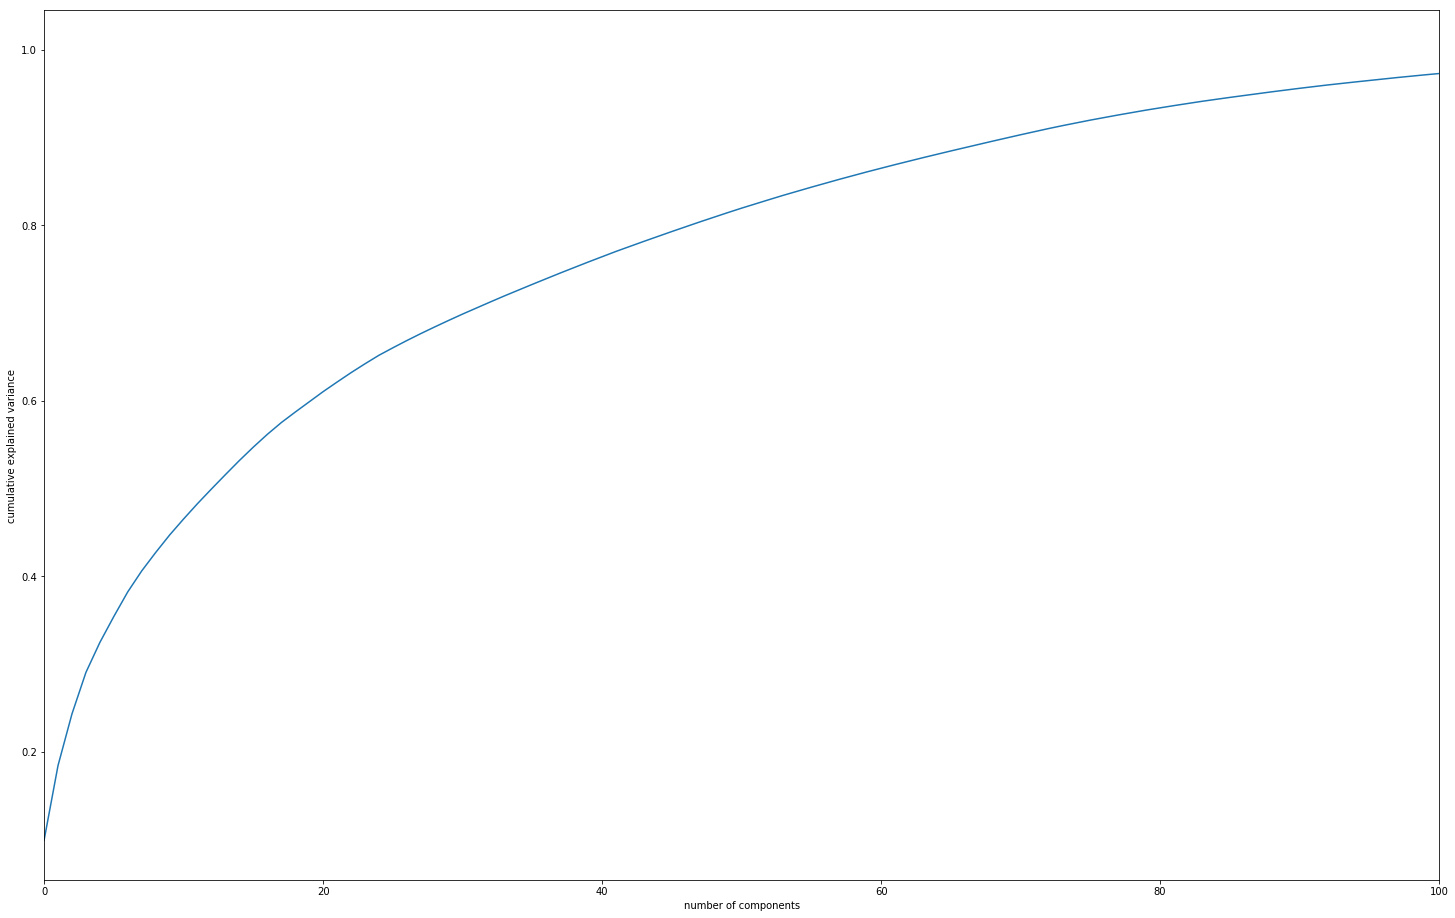

In [169]:
#Plotting the scree plot
%matplotlib inline
fig = plt.figure(figsize = (25,16))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,100)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### Nearly ~80 components are explaining ~90% of the variance

In [170]:
# let PCA select the number of principal components
pca_again = PCA(0.95)

In [171]:
pca3_df = pca_again.fit_transform(X_train_std_df)
pca3_df.shape

(19310, 89)

In [172]:
# Therefore, selecting 5 principal components
pca_final = IncrementalPCA(n_components=89)

In [173]:
pca_final_np = pca_final.fit_transform(X_train_std_df)
pca_final_np.shape

(19310, 89)

In [174]:
# Creating a transpose so that the each column is properly arranged
pca_final_np_tp = np.transpose(pca_final_np)
pca_final_np_tp.shape

(89, 19310)

In [175]:
pca_final_df = pd.DataFrame({'PC0':pca_final_np_tp[0]})

In [176]:
col_name = ''
for i in range(1,len(pca_final_np_tp)):
    col_name = 'PC' + str(i)
    pca_final_df[col_name] = list(pca_final_np_tp[i])

In [177]:
pca_final_df.shape

(19310, 89)

In [178]:
pca_final_df.head(5)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88
0,3.355089,2.266880,0.898800,1.038560,-1.967437,0.160785,0.476230,-2.018725,0.067529,0.226948,-0.827940,0.844929,-0.427562,-0.786367,-0.963511,-0.297092,1.564580,0.201292,0.291271,0.591788,0.274021,-0.479951,-0.029837,-1.317755,0.338993,0.335651,-0.501396,-0.473587,-0.085859,0.804387,0.308173,0.837784,-0.447185,0.394069,0.009656,0.837671,-0.545816,-0.211949,-0.967248,-1.562123,0.327830,1.111715,0.819712,0.414465,1.144050,0.216341,0.204668,-1.018082,-0.381933,0.949358,-0.395074,1.009327,-1.190421,0.055771,-0.401185,0.517433,1.145889,-0.918005,0.547870,0.611807,-0.821285,-0.155013,0.050357,0.236389,1.228895,0.880203,0.308859,-0.072415,0.210201,0.071437,0.942951,-0.245888,-0.102905,0.072558,0.413264,-1.033839,0.579958,-0.934005,0.303844,0.019623,-0.346977,-0.397986,-0.138728,-0.731316,-0.181794,1.293972,-0.106418,-0.442407,-0.411849
1,7.552511,7.426116,-0.174558,-0.081310,-0.704688,-2.429255,2.220640,2.518468,1.121003,-0.000581,0.738588,-2.262867,1.936336,-0.439292,0.870361,-1.433970,0.521875,0.007548,0.185007,0.711072,-1.571359,0.661116,0.441308,-0.392100,-0.327807,-0.312629,0.560189,-0.758300,-1.539162,-1.106577,-0.116123,0.311563,0.967504,0.461685,-0.726601,1.231899,-1.064750,-0.618254,-0.829654,-1.066211,-0.215278,0.900822,-0.439747,0.096010,0.924652,0.428454,-0.411300,0.067483,0.353173,-0.527977,-0.540454,0.129384,0.648036,0.155558,0.172547,-0.448327,-0.121630,-0.447943,0.396645,-0.221997,0.178488,-0.048020,-0.141721,-0.115884,-0.053649,0.468779,0.467741,0.077337,-0.311204,0.096226,0.092771,-0.393614,0.095387,-0.247694,-0.228282,0.108654,-0.868803,0.132294,-1.623417,-1.434167,-2.134132,-0.302035,-0.789203,0.538376,-2.117708,1.001883,0.448518,0.501329,-1.046011
2,-2.186226,-2.965152,0.199038,-1.924353,-0.371821,-1.780044,-0.811731,1.178173,-0.523990,0.805836,-1.016578,0.217455,-0.067800,-0.479436,-0.178361,-0.578950,-0.053810,0.680900,-0.295043,-0.574861,1.118938,0.074265,-0.067020,-0.365767,0.141703,0.649479,0.313902,0.074783,-0.165133,-0.456777,-0.161077,-0.082042,0.382525,0.934862,-0.684842,-0.933803,-0.002389,1.487102,-0.223891,0.567441,0.141704,-0.482326,0.713452,-0.340067,-1.107427,-0.669086,0.387301,-0.105477,-0.280536,-0.511205,0.530918,-0.014521,-0.040713,0.056290,-0.646708,-0.177019,-0.416470,-0.574222,-0.341782,0.330968,-0.565897,-0.831089,0.970289,1.527043,-0.521024,-0.845955,0.889056,-0.054408,0.403364,1.053853,-0.105800,0.011902,0.862229,0.294986,0.956707,0.363627,-0.404589,-0.031154,-0.076587,0.046082,-0.072433,-0.200705,-0.020548,-0.060994,0.192497,0.229125,-0.148530,-0.037504,-0.053066
3,-3.493240,1.519570,3.665939,-1.035990,1.380113,1.383121,-2.156261,3.798699,-1.922602,0.537117,-1.154550,-0.125269,-0.007062,1.975682,-1.186121,0.532114,0.841474,0.429326,-1.049505,-4.691128,-3.888434,-1.150202,-0.253712,0.507920,1.339243,-0.858417,0.465636,0.553058,0.619044,0.142119,2.174957,0.699217,-0.862314,-0.256179,-0.410504,-0.378939,1.160141,0.908133,0.174295,-0.247143,1.428330,0.474328,0.166771,-0.605373,0.064350,-1.188719,-0.091897,0.266694,-0.061184,-1.244479,-1.042243,-0.456696,-0.244669,0.487635,-1.171302,0.831369,0.390740,0.251717,-0.491954,-0.086272,-1.315212,-0.025005,-1.101506,-0.786813,0.505002,0.872273,1.376492,1.219715,-2.119524,-0.148797,-1.359903,-0.220443,0.002646,-0.656238,-0.752567,-1.342314,-0.612147,-0.058141,0.678288,-0.519531,-0.064314,0.103303,0.446436,0.095137,-0.278723,-0.026624,0.356974,-0.067914,-0.616885
4,-0.092988,1.221187,-0.368418,-0.268316,-1.203618,1.715522,-0.463479,0.774431,-1.162825,0.422206,-0.962485,0.735783,-0.328691,0.486907,0.889317,0.673296,0.376977,

### Model Building - Using Logistic Regression

#### Feature Selection

In [179]:
logreg = LogisticRegression()

In [180]:
rfe = RFE(logreg, 30)             # running RFE with 30 variables as output
rfe = rfe.fit(pca_final_df, y_train)

In [181]:
list(zip(pca_final_df.columns, rfe.support_, rfe.ranking_))

[('PC0', False, 41),
 ('PC1', True, 1),
 ('PC2', True, 1),
 ('PC3', True, 1),
 ('PC4', True, 1),
 ('PC5', True, 1),
 ('PC6', False, 46),
 ('PC7', False, 20),
 ('PC8', False, 51),
 ('PC9', True, 1),
 ('PC10', False, 36),
 ('PC11', False, 54),
 ('PC12', False, 28),
 ('PC13', True, 1),
 ('PC14', False, 10),
 ('PC15', False, 58),
 ('PC16', False, 34),
 ('PC17', False, 43),
 ('PC18', False, 21),
 ('PC19', True, 1),
 ('PC20', True, 1),
 ('PC21', True, 1),
 ('PC22', False, 22),
 ('PC23', False, 12),
 ('PC24', False, 47),
 ('PC25', False, 39),
 ('PC26', False, 26),
 ('PC27', False, 27),
 ('PC28', True, 1),
 ('PC29', False, 37),
 ('PC30', False, 15),
 ('PC31', False, 18),
 ('PC32', False, 30),
 ('PC33', True, 1),
 ('PC34', True, 1),
 ('PC35', True, 1),
 ('PC36', False, 49),
 ('PC37', False, 3),
 ('PC38', False, 5),
 ('PC39', False, 17),
 ('PC40', True, 1),
 ('PC41', False, 44),
 ('PC42', False, 4),
 ('PC43', False, 59),
 ('PC44', True, 1),
 ('PC45', False, 6),
 ('PC46', True, 1),
 ('PC47', Fals

In [182]:
rfe_retained_col = pca_final_df.columns[rfe.support_]

In [183]:
len(rfe_retained_col)

30

In [184]:
pca_final_df[rfe_retained_col].head(5)

,PC1,PC2,PC3,PC4,PC5,PC9,PC13,PC19,PC20,PC21,PC28,PC33,PC34,PC35,PC40,PC44,PC46,PC48,PC52,PC53,PC54,PC57,PC58,PC69,PC75,PC77,PC78,PC83,PC85,PC86
0,2.266880,0.898800,1.038560,-1.967437,0.160785,0.226948,-0.786367,0.591788,0.274021,-0.479951,-0.085859,0.394069,0.009656,0.837671,0.327830,1.144050,0.204668,-0.381933,-1.190421,0.055771,-0.401185,-0.918005,0.547870,0.071437,-1.033839,-0.934005,0.303844,-0.731316,1.293972,-0.106418
1,7.426116,-0.174558,-0.081310,-0.704688,-2.429255,-0.000581,-0.439292,0.711072,-1.571359,0.661116,-1.539162,0.461685,-0.726601,1.231899,-0.215278,0.924652,-0.411300,0.353173,0.648036,0.155558,0.172547,-0.447943,0.396645,0.096226,0.108654,0.132294,-1.623417,0.538376,1.001883,0.448518
2,-2.965152,0.199038,-1.924353,-0.371821,-1.780044,0.805836,-0.479436,-0.574861,1.118938,0.074265,-0.165133,0.934862,-0.684842,-0.933803,0.141704,-1.107427,0.387301,-0.280536,-0.040713,0.056290,-0.646708,-0.574222,-0.341782,1.053853,0.363627,-0.031154,-0.076587,-0.060994,0.229125,-0.148530
3,1.519570,3.665939,-1.035990,1.380113,1.383121,0.537117,1.975682,-4.691128,-3.888434,-1.150202,0.619044,-0.256179,-0.410504,-0.378939,1.428330,0.064350,-0.091897,-0.061184,-0.244669,0.487635,-1.171302,0.251717,-0.491954,-0.148797,-1.342314,-0.058141,0.678288,0.095137,-0.026624,0.356974
4,1.221187,-0.368418,-0.268316,-1.203618,1.715522,0.422206,0.486907,1.805656,1.628552,-0.639869,-1.141687,-1.958154,-0.465712,-0.057684,0.835804,-1.231594,0.162591,-1.040688,0.316090,0.428337,-0.254035,1.089546,0.508685,0.772208,0.772283,0.073713,-0.598193,-0.645971,0.565653,-0.456380


In [185]:
pca_final_df[rfe_retained_col].head(10)

,PC1,PC2,PC3,PC4,PC5,PC9,PC13,PC19,PC20,PC21,PC28,PC33,PC34,PC35,PC40,PC44,PC46,PC48,PC52,PC53,PC54,PC57,PC58,PC69,PC75,PC77,PC78,PC83,PC85,PC86
0,2.266880,0.898800,1.038560,-1.967437,0.160785,0.226948,-0.786367,0.591788,0.274021,-0.479951,-0.085859,0.394069,0.009656,0.837671,0.327830,1.144050,0.204668,-0.381933,-1.190421,0.055771,-0.401185,-0.918005,0.547870,0.071437,-1.033839,-0.934005,0.303844,-0.731316,1.293972,-0.106418
1,7.426116,-0.174558,-0.081310,-0.704688,-2.429255,-0.000581,-0.439292,0.711072,-1.571359,0.661116,-1.539162,0.461685,-0.726601,1.231899,-0.215278,0.924652,-0.411300,0.353173,0.648036,0.155558,0.172547,-0.447943,0.396645,0.096226,0.108654,0.132294,-1.623417,0.538376,1.001883,0.448518
2,-2.965152,0.199038,-1.924353,-0.371821,-1.780044,0.805836,-0.479436,-0.574861,1.118938,0.074265,-0.165133,0.934862,-0.684842,-0.933803,0.141704,-1.107427,0.387301,-0.280536,-0.040713,0.056290,-0.646708,-0.574222,-0.341782,1.053853,0.363627,-0.031154,-0.076587,-0.060994,0.229125,-0.148530
3,1.519570,3.665939,-1.035990,1.380113,1.383121,0.537117,1.975682,-4.691128,-3.888434,-1.150202,0.619044,-0.256179,-0.410504,-0.378939,1.428330,0.064350,-0.091897,-0.061184,-0.244669,0.487635,-1.171302,0.251717,-0.491954,-0.148797,-1.342314,-0.058141,0.678288,0.095137,-0.026624,0.356974
4,1.221187,-0.368418,-0.268316,-1.203618,1.715522,0.422206,0.486907,1.805656,1.628552,-0.639869,-1.141687,-1.958154,-0.465712,-0.057684,0.835804,-1.231594,0.162591,-1.040688,0.316090,0.428337,-0.254035,1.089546,0.508685,0.772208,0.772283,0.073713,-0.598193,-0.645971,0.565653,-0.456380
5,-0.485392,3.028442,-3.189419,-1.192243,-0.390354,-2.868199,0.762433,0.792480,-0.823570,0.558161,0.478947,0.270091,-0.037208,0.954124,-0.279349,0.176069,0.652933,-0.395917,0.017290,0.766417,-1.162881,0.798477,0.788868,0.756230,1.285681,0.796749,-0.573966,0.087197,0.028685,-0.060723
6,-5.050663,-0.092028,3.815280,0.378948,-0.403442,0.257228,1.196312,0.591987,-1.090360,-0.248691,0.253878,-0.593699,-0.297471,-0.168307,-0.359318,0.460824,-0.406194,0.570808,-0.710817,-0.237860,0.179033,-0.507642,-0.391241,0.560367,0.323772,-0.292574,0.133556,0.072735,0.304481,0.316816
7,2.870774,-0.846281,-3.737843,0.393882,-1.406237,-1.412819,3.679327,2.886964,0.317788,0.855848,0.372217,0.690115,0.665544,-0.530651,-0.605195,0.412085,-0.918081,1.137202,-0.489322,-0.537298,1.443082,1.979452,-0.261807,-0.747359,-0.159825,-0.178190,-0.403450,0.833506,-0.451868,2.454339
8,2.114658,-2.748198,-1.422364,0.011477,0.024665,-1.268810,-0.176559,-1.061123,-2.849731,-0.126314,0.752178,0.247698,1.679899,0.191320,-0.022032,1.300121,1.619165,-0.261500,-0.356859,-0.261812,0.742944,-0.142000,-0.421692,-0.719769,-0.210661,0.483048,-0.368770,0.754827,0.191996,0.243614
9,4.176335,-1.433900,0.327192,0.324241,-0.429759,0.269845,-2.422218,-4.047359,-4.898844,0.067218,2.232856,-0.051244,-0.375360,-0.156607,0.026743,0.473860,0.967961,0.009877,-0.861644,-0.574975,0.453201,-0.744712,1.759774,-0.883410,0.707154,0.839552,-0.319403,-0.949674,-0.642502,0.014017


In [186]:
y_train_df = pd.DataFrame({'y_train':y_train})

In [187]:
y_train_df.reset_index(inplace=True)

In [188]:
y_train_df.drop(['index'],axis=1,inplace=True)

In [189]:
y_train_df.shape

(19310, 1)

In [190]:
y_train_df.head(10)

,y_train
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


#### Assessing the model with StatsModels

In [191]:
pca_final_df_sm = sm.add_constant(pca_final_df[rfe_retained_col])
logm = sm.GLM(y_train_df,pca_final_df_sm, family = sm.families.Binomial())
res = logm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                y_train   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19279
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1563.0
Date:                Sat, 02 Nov 2019   Deviance:                       3126.1
Time:                        12:30:47   Pearson chi2:                 2.09e+05
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1970      0.159    -39.014      0.000      -6.508      -5.886
PC1           -0.6217      0.035    -17.566      0.000      -0.691      -0.552
PC2            0.4924      0.032     15.591      0.000       0.431       0.554
PC3           -0.4996      0.034    -14.481      0.000      -0.567      -0.432
PC4           -0.1681      0.043     -3.951      0.000      -0.252      -0.085
PC5           -0.1793      0.034     -5.255      0.000      -0.246      -0.112
PC9            0.2545      0.025     10.150      0.000       0.205       0.304
PC13           0.5083      0.034     14.861      0.000       0.441       0.575
PC19          -0.4131      0.041    -10.187      0.000      -0.493      -0.334
PC20           0.1795      0.043      4.164      0.000       0.095       0.264
PC21          -0.1817      0.087     -2.092      0.036      -0.352      -0.011
PC28           0.2230      0.054      4.123      0.000       0.117       0.329
PC33           0.2142      0.060      3.553      0.000       0.096       0.332
PC34          -0.2868      0.081     -3.528      0.000      -0.446      -0.127
PC35          -0.2494      0.069     -3.601      0.000      -0.385      -0.114
PC40          -0.3859      0.062     -6.225      0.000      -0.507      -0.264
PC44          -0.2067      0.062     -3.314      0.001      -0.329      -0.084
PC46           0.1719      0.073      2.362      0.018       0.029       0.315
PC48          -0.3241      0.091     -3.547      0.000      -0.503      -0.145
PC52           0.2562      0.063      4.038      0.000       0.132       0.380
PC53          -0.5089      0.133     -3.825      0.000      -0.770      -0.248
PC54           0.3828      0.108      3.560      0.000       0.172       0.594
PC57          -0.3909      0.064     -6.101      0.000      -0.517      -0.265
PC58           0.3600      0.076      4.763      0.000       0.212       0.508
PC69           0.1849      0.070      2.643      0.008       0.048       0.322
PC75           0.1759      0.065      2.726      0.006       0.049       0.302
PC77          -0.1789      0.079     -2.261      0.024      -0.334      -0.024
PC78           0.3968      0.080      4.945      0.000       0.240       0.554
PC83          -0.2113      0.141     -1.494      0.135      -0.489       0.066
PC85          -0.1726      0.111     -1.553      0.121      -0.391       0.045
PC86           0.4313      0.100      4.295      0.000       0.234       0.628
==============================================================================
"""

#### Checking VIF

In [192]:
vif = pd.DataFrame()
vif['Features'] = pca_final_df[rfe_retained_col].columns
vif['VIF'] = [variance_inflation_factor(pca_final_df[rfe_retained_col].values, i) for i in range(pca_final_df[rfe_retained_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
19,PC53,1.01
0,PC1,1.00
1,PC2,1.00
28,PC85,1.00
27,PC83,1.00
26,PC78,1.00
25,PC77,1.00
24,PC75,1.00
23,PC69,1.00
22,PC58,1.00


#### VIF of all variables in in acceptable range i.e. < 5
#### Based on the p_value need to drop few

In [193]:
rfe_retained_col3 = list(rfe_retained_col.copy())

In [194]:
rfe_retained_col3.remove('PC21')
rfe_retained_col3.remove('PC46')
rfe_retained_col3.remove('PC77')
rfe_retained_col3.remove('PC83')
rfe_retained_col3.remove('PC85')

In [195]:
pca_final_df_sm3 = sm.add_constant(pca_final_df[rfe_retained_col3])
logm3 = sm.GLM(y_train_df,pca_final_df_sm3, family = sm.families.Binomial())
res3 = logm3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                y_train   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19284
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1575.2
Date:                Sat, 02 Nov 2019   Deviance:                       3150.4
Time:                        12:33:51   Pearson chi2:                 1.41e+05
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1349      0.155    -39.667      0.000      -6.438      -5.832
PC1           -0.6018      0.034    -17.670      0.000      -0.669      -0.535
PC2            0.4843      0.032     15.255      0.000       0.422       0.546
PC3           -0.4970      0.035    -14.337      0.000      -0.565      -0.429
PC4           -0.1739      0.042     -4.116      0.000      -0.257      -0.091
PC5           -0.1919      0.033     -5.803      0.000      -0.257      -0.127
PC9            0.2440      0.025      9.952      0.000       0.196       0.292
PC13           0.5205      0.034     15.494      0.000       0.455       0.586
PC19          -0.4307      0.038    -11.454      0.000      -0.504      -0.357
PC20           0.1923      0.042      4.576      0.000       0.110       0.275
PC28           0.2332      0.053      4.397      0.000       0.129       0.337
PC33           0.1619      0.057      2.830      0.005       0.050       0.274
PC34          -0.2487      0.069     -3.599      0.000      -0.384      -0.113
PC35          -0.2602      0.065     -3.988      0.000      -0.388      -0.132
PC40          -0.4260      0.057     -7.465      0.000      -0.538      -0.314
PC44          -0.1899      0.066     -2.899      0.004      -0.318      -0.062
PC48          -0.3885      0.084     -4.602      0.000      -0.554      -0.223
PC52           0.2103      0.061      3.422      0.001       0.090       0.331
PC53          -0.4922      0.129     -3.801      0.000      -0.746      -0.238
PC54           0.3513      0.105      3.360      0.001       0.146       0.556
PC57          -0.3797      0.064     -5.902      0.000      -0.506      -0.254
PC58           0.3809      0.071      5.356      0.000       0.242       0.520
PC69           0.0840      0.044      1.898      0.058      -0.003       0.171
PC75           0.1176      0.063      1.868      0.062      -0.006       0.241
PC78           0.3967      0.082      4.852      0.000       0.236       0.557
PC86           0.4112      0.092      4.473      0.000       0.231       0.591
==============================================================================
"""

In [196]:
# Based on above removing few more
rfe_retained_col5 = list(rfe_retained_col3.copy())
rfe_retained_col5.remove('PC69')
rfe_retained_col5.remove('PC75')

In [197]:
pca_final_df_sm5 = sm.add_constant(pca_final_df[rfe_retained_col5])
logm5 = sm.GLM(y_train_df,pca_final_df_sm5, family = sm.families.Binomial())
res5 = logm5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                y_train   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19286
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1578.5
Date:                Sat, 02 Nov 2019   Deviance:                       3157.0
Time:                        12:34:32   Pearson chi2:                 1.36e+05
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1169      0.154    -39.736      0.000      -6.419      -5.815
PC1           -0.5994      0.034    -17.628      0.000      -0.666      -0.533
PC2            0.4845      0.032     15.365      0.000       0.423       0.546
PC3           -0.4944      0.034    -14.380      0.000      -0.562      -0.427
PC4           -0.1642      0.042     -3.878      0.000      -0.247      -0.081
PC5           -0.1832      0.032     -5.667      0.000      -0.246      -0.120
PC9            0.2415      0.025      9.830      0.000       0.193       0.290
PC13           0.5201      0.034     15.494      0.000       0.454       0.586
PC19          -0.4255      0.038    -11.343      0.000      -0.499      -0.352
PC20           0.1999      0.041      4.844      0.000       0.119       0.281
PC28           0.2382      0.053      4.534      0.000       0.135       0.341
PC33           0.1453      0.057      2.558      0.011       0.034       0.257
PC34          -0.2413      0.066     -3.662      0.000      -0.370      -0.112
PC35          -0.2652      0.065     -4.059      0.000      -0.393      -0.137
PC40          -0.4074      0.056     -7.285      0.000      -0.517      -0.298
PC44          -0.1943      0.066     -2.927      0.003      -0.324      -0.064
PC48          -0.3700      0.081     -4.547      0.000      -0.529      -0.210
PC52           0.1936      0.061      3.150      0.002       0.073       0.314
PC53          -0.4929      0.129     -3.811      0.000      -0.746      -0.239
PC54           0.3392      0.104      3.259      0.001       0.135       0.543
PC57          -0.3916      0.063     -6.201      0.000      -0.515      -0.268
PC58           0.3512      0.070      5.044      0.000       0.215       0.488
PC78           0.3880      0.081      4.791      0.000       0.229       0.547
PC86           0.4116      0.092      4.490      0.000       0.232       0.591
==============================================================================
"""

In [198]:
rfe_retained_col5.remove('PC33')

In [199]:
pca_final_df_sm5 = sm.add_constant(pca_final_df[rfe_retained_col5])
logm5 = sm.GLM(y_train_df,pca_final_df_sm5, family = sm.families.Binomial())
res5 = logm5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                y_train   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19287
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1581.7
Date:                Sat, 02 Nov 2019   Deviance:                       3163.5
Time:                        12:34:57   Pearson chi2:                 1.86e+05
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1408      0.154    -39.747      0.000      -6.444      -5.838
PC1           -0.6044      0.034    -17.863      0.000      -0.671      -0.538
PC2            0.4899      0.032     15.516      0.000       0.428       0.552
PC3           -0.5077      0.034    -14.748      0.000      -0.575      -0.440
PC4           -0.1596      0.042     -3.789      0.000      -0.242      -0.077
PC5           -0.1850      0.033     -5.683      0.000      -0.249      -0.121
PC9            0.2329      0.024      9.569      0.000       0.185       0.281
PC13           0.5238      0.033     15.667      0.000       0.458       0.589
PC19          -0.4269      0.037    -11.418      0.000      -0.500      -0.354
PC20           0.2058      0.040      5.119      0.000       0.127       0.285
PC28           0.2434      0.051      4.784      0.000       0.144       0.343
PC34          -0.2159      0.061     -3.522      0.000      -0.336      -0.096
PC35          -0.2743      0.066     -4.181      0.000      -0.403      -0.146
PC40          -0.4016      0.052     -7.655      0.000      -0.504      -0.299
PC44          -0.2073      0.066     -3.118      0.002      -0.338      -0.077
PC48          -0.3523      0.078     -4.497      0.000      -0.506      -0.199
PC52           0.1796      0.060      2.971      0.003       0.061       0.298
PC53          -0.4023      0.121     -3.319      0.001      -0.640      -0.165
PC54           0.3877      0.101      3.832      0.000       0.189       0.586
PC57          -0.4172      0.060     -6.903      0.000      -0.536      -0.299
PC58           0.3568      0.067      5.311      0.000       0.225       0.489
PC78           0.3811      0.081      4.688      0.000       0.222       0.540
PC86           0.4057      0.093      4.383      0.000       0.224       0.587
==============================================================================
"""

In [200]:
vif = pd.DataFrame()
vif['Features'] = pca_final_df[rfe_retained_col5].columns
vif['VIF'] = [variance_inflation_factor(pca_final_df[rfe_retained_col5].values, i) for i in range(pca_final_df[rfe_retained_col5].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
16,PC53,1.01
0,PC1,1.00
1,PC2,1.00
20,PC78,1.00
19,PC58,1.00
18,PC57,1.00
17,PC54,1.00
15,PC52,1.00
14,PC48,1.00
13,PC44,1.00


### All p-values are significantly lower than 0.05 and All VIFs are also significantly lower than 5

In [201]:
# Getting the predicted values on the train set
y_train_pred = res5.predict(pca_final_df_sm5)
y_train_pred[:10]

0    0.000304
1    0.000008
2    0.110030
3    0.025462
4    0.000368
5    0.014322
6    0.010584
7    0.004945
8    0.000155
9    0.000234
dtype: float64

In [202]:
y_train_pred = res5.predict(pca_final_df_sm5).values.reshape(-1)
y_train_pred[:10]

array([3.04438505e-04, 7.95544826e-06, 1.10030346e-01, 2.54615193e-02,
       3.68277588e-04, 1.43215815e-02, 1.05836066e-02, 4.94507932e-03,
       1.54531789e-04, 2.33532909e-04])

#### Creating a dataframe with the actual converted flag and the predicted probabilities

In [203]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final.head()

,Converted,Converted_Prob
0,0,0.000304
1,0,0.000008
2,0,0.110030
3,0,0.025462
4,0,0.000368


#### Creating new column 'predicted' with 1 if Converted_Prob > 0.5 else 0

In [204]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_Prob,predicted
0,0,0.000304,0
1,0,0.000008,0
2,0,0.110030,0
3,0,0.025462,0
4,0,0.000368,0


In [205]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
print(confusion)

[[18768    35]
 [  467    40]]


In [206]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9740031071983428


### Metrics beyond simply accuracy

In [207]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [208]:
# Let's see the sensitivity of our logistic regression model / Recall
TP / float(TP+FN)

0.07889546351084813

In [209]:
# Let us calculate specificity
TN / float(TN+FP)

0.9981385949050683

In [210]:
# Calculate false postive rate - predicting converted when customer does not get converted
print(FP / float(TN+FP))

0.0018614050949316598


In [211]:
# Precicion / positive predictive value 
print (TP / float(TP+FP))

0.5333333333333333


In [212]:
# Negative predictive value
print (TN / float(TN+FN))

0.975721341304913


### Model is very low on Sensitivity and Precision but high on Accuracy and Specificity

### Plotting ROC Curve

In [213]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return None

In [214]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

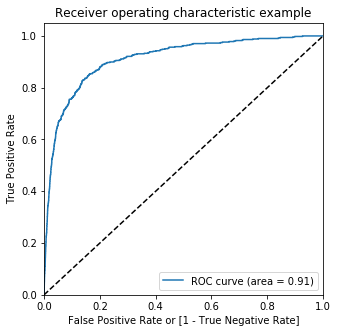

In [215]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

#### Area under the ROC curve i.e. AUC is 91%

###  Finding Optimal Cutoff Point

In [216]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.000304,0,1,0,0,0,0,0,0,0,0,0
1,0,0.000008,0,1,0,0,0,0,0,0,0,0,0
2,0,0.110030,0,1,1,0,0,0,0,0,0,0,0
3,0,0.025462,0,1,0,0,0,0,0,0,0,0,0
4,0,0.000368,0,1,0,0,0,0,0,0,0,0,0


In [217]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.026256  1.000000  0.000000
0.1   0.1  0.945417  0.642998  0.953571
0.2   0.2  0.965562  0.410256  0.980535
0.3   0.3  0.971258  0.240631  0.990959
0.4   0.4  0.973123  0.136095  0.995692
0.5   0.5  0.974003  0.078895  0.998139
0.6   0.6  0.973951  0.043393  0.999043
0.7   0.7  0.973744  0.021696  0.999415
0.8   0.8  0.973796  0.011834  0.999734
0.9   0.9  0.973744  0.003945  0.999894


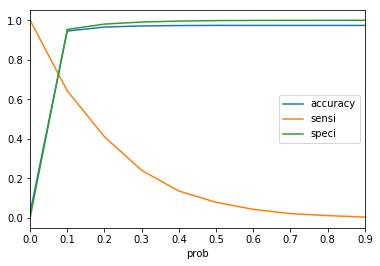

In [218]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, ~0.08 looks like the optimum point to take it as a cutoff probability. However, by taking cutoff at around ~0.03 we are getting optimal values of accuracy and sensitivity i.e. both > 0.8

In [744]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.03 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.000304,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.000008,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.110030,0,1,1,0,0,0,0,0,0,0,0,1
3,0,0.025462,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.000368,0,1,0,0,0,0,0,0,0,0,0,0


In [745]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8292594510616261

In [746]:
confusion3 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion3

array([[15580,  3223],
       [   74,   433]], dtype=int64)

In [747]:
TP3 = confusion3[1,1] # true positive 
TN3 = confusion3[0,0] # true negatives
FP3 = confusion3[0,1] # false positives
FN3 = confusion3[1,0] # false negatives

In [748]:
# Let's see the sensitivity of our logistic regression model / Recall
TP3 / float(TP3+FN3)

0.854043392504931

In [749]:
# Let us calculate specificity
TN3 / float(TN3+FP3)

0.8285911822581503

### Making predictions on the test set

In [267]:
X_test_std_df = standard_scaler.transform(X_test)

In [268]:
pca_final_test_np = pca_final.transform(X_test_std_df)

In [269]:
pca_final_test_np.shape

(8277, 89)

In [270]:
# Creating a transpose so that the each column is properly arranged
pca_final_test_np_tp = np.transpose(pca_final_test_np)
pca_final_test_np_tp.shape

(89, 8277)

In [271]:
pca_final_test_df = pd.DataFrame({'PC0':pca_final_test_np_tp[0]})

col_name = ''
for i in range(1, len(pca_final_test_np_tp)):
    col_name = 'PC' + str(i)
    pca_final_test_df[col_name] = list(pca_final_test_np_tp[i])

In [272]:
pca_final_test_df.shape

(8277, 89)

In [273]:
pca_final_test_df.head(5)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88
0,5.538009,0.016807,0.789929,-3.272059,-0.659936,-0.790972,0.603962,0.282688,-0.071851,-0.087185,-0.658667,0.041554,-0.061559,1.088076,1.174211,1.029328,1.441371,-1.203590,-0.358943,0.569959,0.007309,1.237640,0.353730,3.083134,-0.671608,-0.162182,0.007849,-0.691652,-1.102651,-0.740348,1.169416,0.520217,1.201108,0.728798,-0.618920,0.282173,-0.046191,0.381968,-0.550317,-0.494582,0.573783,-0.025766,1.163804,-0.493772,-1.873731,0.058668,-0.486737,-0.040493,-0.569111,1.587029,-0.542909,0.779737,1.490743,0.427652,-0.236811,0.129866,-0.179557,-0.084699,0.231778,-0.666708,1.459032,-0.444406,-0.362596,-0.097440,-1.095168,-1.242127,0.162448,0.460552,0.318445,0.129979,0.032251,0.989987,-0.383519,0.078462,-0.759243,-0.576829,-0.082004,-0.454456,0.014090,0.177631,-0.301248,-0.921928,0.042502,0.388353,-0.330736,0.232518,0.118008,-0.371526,0.169892
1,-1.152368,-2.531826,-1.351471,-2.204361,-1.116784,-1.916287,-0.513721,-0.360137,0.225784,0.303914,-0.723030,0.146052,-0.380635,-0.551367,0.263673,-0.225934,0.188163,-0.410902,-0.070166,0.177067,-0.194976,0.437639,0.107658,-0.451673,-0.010826,0.818097,-0.049039,-0.546800,0.221325,0.065422,-0.525817,0.238887,-0.475173,-0.643550,0.317572,0.471443,0.756400,0.515349,0.510574,-0.706025,0.400928,-0.125975,-0.165051,-0.060923,-0.558223,-1.021587,0.985723,0.553178,-0.474114,-1.003825,-1.159595,0.650955,-0.540285,-0.028311,-0.503526,-1.242644,-0.502599,-0.012187,0.432633,1.034841,1.087831,-0.039705,0.132728,1.086149,0.049284,0.824473,-0.367735,0.501063,-0.106197,1.091382,-0.797538,0.014182,-0.133400,-0.392662,0.602426,0.258721,-0.924859,-0.308393,0.457056,0.115232,0.355901,0.242519,0.088014,-0.187077,-0.012653,0.066321,-0.367154,0.148438,0.244633
2,6.162996,1.340579,2.278595,-2.519768,-0.665568,0.046057,0.488920,0.928991,0.326314,0.554360,-0.565903,-0.361578,0.412464,-0.953852,1.343802,-0.352709,-0.664881,0.249977,-0.261420,-1.568338,-2.058531,-0.619079,0.081835,-0.709592,0.263878,-0.618692,-0.991414,-0.483947,0.402368,-0.739508,-1.868298,0.363046,0.704278,-0.081747,0.896558,-0.800876,-0.288691,-0.773563,-0.460575,0.163971,0.329757,-0.376939,0.219438,0.138270,0.742948,-0.961306,1.463157,-0.734477,-0.085013,0.352811,0.022143,0.211206,-0.623559,0.248493,0.240102,-1.086015,-0.836726,-0.189203,0.479638,0.891147,0.109423,-0.410361,0.486838,-0.602000,-0.544590,-0.429619,0.269335,0.564637,0.458830,-0.448835,0.364338,0.928219,0.850566,-0.329157,-0.887255,0.361788,0.224722,-0.370641,0.267886,0.411160,0.025605,-0.350394,-0.083612,0.404454,-0.153277,0.085760,0.148157,-0.280887,0.229001
3,-6.864560,1.880963,3.882997,0.155462,-2.521091,1.110566,2.644249,-2.508940,0.170803,-0.053730,-0.832236,-0.380231,0.025844,-0.179547,-0.814830,-0.601069,-0.637621,0.117898,0.101723,0.222988,0.139185,0.356274,-0.592381,-0.228629,-0.164179,0.810809,-0.180651,-0.452827,0.033793,-0.547949,0.111550,-0.415623,-0.307642,0.604596,-0.700888,-0.855212,0.002953,0.326434,-0.237229,0.979234,-0.107989,-0.100569,-0.757606,-0.354146,-0.240880,0.038020,-0.620706,-0.225421,0.100626,-0.539387,-0.150858,-0.691124,0.147752,-0.174503,0.180074,-0.503533,-0.201640,-0.579166,-0.939083,0.164117,1.049576,-0.266578,0.800989,0.863324,-0.738982,-0.268694,-0.402943,-1.129636,0.487607,0.502582,1.645509,0.139638,1.564756,0.305954,-1.099982,0.313111,-1.132417,-0.763864,0.238237,-0.152077,0.732452,-0.118283,-0.044451,-0.402159,0.108101,-0.145520,-1.014382,-0.173159,0.181738
4,0.937066,-0.298636,-1.941509,-2.529118,-1.430806,-1.501904,-0.018593,-0.886763,-0.703574,-0.250025,-0.710709,-0.575454,-0.462393,1.789939,-0.464641,0.625850,0.531884,

In [274]:
pca_final_test_df_sm = sm.add_constant(pca_final_test_df[rfe_retained_col5])

In [275]:
y_test_pred = res5.predict(pca_final_test_df_sm)

In [276]:
y_test_pred[:10]

0    0.038354
1    0.016746
2    0.011875
3    0.005344
4    0.007028
5    0.001381
6    0.000709
7    0.000055
8    0.000005
9    0.013585
dtype: float64

In [277]:
# Converting y_pred to a dataframe which is an array
y_test_pred_df = pd.DataFrame(y_test_pred)

In [278]:
y_test_pred_df.head(5)

,0
0,0.038354
1,0.016746
2,0.011875
3,0.005344
4,0.007028


In [279]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [280]:
y_test_df.head(5)

,churn
87201,0
39261,0
84211,0
24672,0
94133,0


In [281]:
# Removing index for both dataframes to append them side by side 
y_test_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [282]:
# Appending y_test_df and y_test_pred_df
y_pred_final = pd.concat([y_test_df, y_test_pred_df],axis=1)

In [283]:
y_pred_final.head()

,churn,0
0,0,0.038354
1,0,0.016746
2,0,0.011875
3,0,0.005344
4,0,0.007028


In [284]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Churn'})

In [285]:
# Let's see the head of y_pred_final
y_pred_final.head()

,churn,Converted_Churn
0,0,0.038354
1,0,0.016746
2,0,0.011875
3,0,0.005344
4,0,0.007028


In [736]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Churn.map(lambda x: 1 if x > 0.03 else 0)

In [737]:
y_pred_final.head()

,churn,Converted_Churn,final_predicted
0,0,0.038354,1
1,0,0.016746,0
2,0,0.011875,0
3,0,0.005344,0
4,0,0.007028,0


In [738]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.final_predicted)

0.8244533043373203

In [739]:
confusion_test = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.final_predicted)
confusion_test

array([[6617, 1412],
       [  41,  207]], dtype=int64)

In [740]:
TP_test = confusion_test[1,1] # true positive 
TN_test = confusion_test[0,0] # true negatives
FP_test = confusion_test[0,1] # false positives
FN_test = confusion_test[1,0] # false negatives

In [741]:
# Let's see the sensitivity of our logistic regression model
TP_test / float(TP_test+FN_test)

0.8346774193548387

In [742]:
# Let us calculate specificity
TN_test / float(TN_test+FP_test)

0.8241375015568564

#### By tweaking the cutooff probability value here also to 0.03 we see that the accuracy is 0.82.Also, the Sensitivity has increased is 0.83. On further reducing the cutoff probability the accuracy takes further hit and goes below 0.8 therefore, by going ahead with 0.03 probability cutoff we get the following metrics comparison between train and test data

         Train Data  Test Data
- Accuracy - 	    0.83              0.82
- Sensitivity - 	0.85		      0.83
- Specificity - 	0.83		      0.82

Seeing the above results the following can be derived
- The Models performance on test data is similar to that on train data
- The key metric here is Sentivity because we need to predict the customers who churn accurately. Here we have 0.83 as the value for sentivity
- On further reducing the cutoff probability the sensitivity improves but the accuracy gets reduced futher and falls well below 0.8. Therefore, now we have optimal values for accuracy, specificity and sensitivity

#### Trying out with other classfication related learning algorithms to see if they perform better here

### Model Building - Decision Tree

In [364]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree

dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(pca_final_df, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [365]:
# Making predictions
y_pred_default = dt_default.predict(pca_final_test_df)

# Printing classification report
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8029
           1       0.29      0.06      0.10       248

   micro avg       0.97      0.97      0.97      8277
   macro avg       0.63      0.53      0.54      8277
weighted avg       0.95      0.97      0.96      8277



In [366]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[7993   36]
 [ 233   15]]
0.9675003020418026


However, the Sensitivity looks very low here. Therefore, need Hyperparameter tuning

### Hyperparameter Tuning - Max_Depth

In [369]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(pca_final_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [370]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.182915,0.018626,0.001598,0.003195,1,{'max_depth': 1},0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.973720,0.973720,0.973744,0.000030
1,0.397955,0.061829,0.002384,0.001947,2,{'max_depth': 2},0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.973720,0.973720,0.973744,0.000030
2,0.444126,0.005920,0.003926,0.006055,3,{'max_depth': 3},0.973596,0.973596,0.973848,0.973841,0.973064,0.973589,0.000285,3,0.973781,0.973846,0.973783,0.973914,0.974044,0.973874,0.000098
3,0.609048,0.046120,0.000799,0.001599,4,{'max_depth': 4},0.971525,0.971784,0.972812,0.971769,0.973323,0.972242,0.000699,4,0.974429,0.974623,0.975401,0.974950,0.974950,0.974871,0.000332
4,0.837421,0.089078,0.006312,0.004653,5,{'max_depth': 5},0.969713,0.973078,0.972294,0.972287,0.972546,0.971983,0.001171,5,0.975918,0.976565,0.977084,0.975986,0.975921,0.976295,0.000464


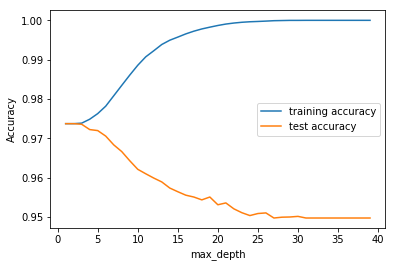

In [371]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that as we increase the value of max_depth, both training and test score are constant till about max-depth ~ 3, after which the test score gradually reduces. Thus, it is clear that the model is overfitting the training data if the max_depth is too high. Next, let's see how the model behaves with other hyperparameters.

### Hyperparameter Tuning - min_samples_leaf

The hyperparameter min_samples_leaf indicates the minimum number of samples required to be at a leaf

In [372]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")

tree.fit(pca_final_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

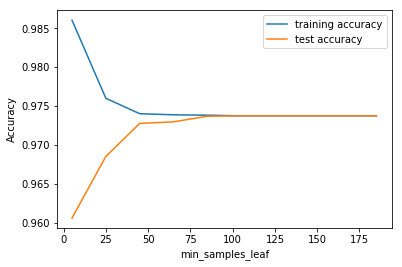

In [373]:
# plotting accuracies with min_samples_leaf
scores = tree.cv_results_

plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It can be seen that at low values of min_samples_leaf, the tree gets a bit overfitted. 
At values > 75, however, the model becomes more stable and the training and test accuracy start to converge.

### Hyperparameter Tuning - min_samples_split

The hyperparameter min_samples_split is the minimum no. of samples required to split an internal node. Its default value is 2, which means that even if a node is having 2 samples it can be furthur divided into leaf nodes.

In [374]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(pca_final_df, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

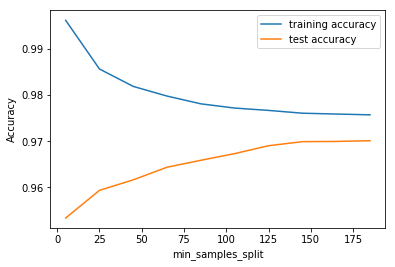

In [375]:
scores = tree.cv_results_
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

This shows that as you increase the min_samples_split, the tree overfits lesser since the model is less complex.

### Grid Search to Find Optimal Hyperparameters

In [376]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(1, 5, 1),
    'min_samples_leaf': range(75, 175, 25),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(pca_final_df,y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(75, 175, 25), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [377]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.295660,0.035614,0.001598,0.001958,entropy,1,75,50,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
1,0.303416,0.058223,0.002031,0.001768,entropy,1,75,100,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
2,0.339366,0.048527,0.002355,0.001923,entropy,1,100,50,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
3,0.350114,0.057675,0.002394,0.001955,entropy,1,100,100,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
4,0.353781,0.043231,0.003978,0.000022,entropy,1,125,50,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
5,0.322617,0.061329,0.006310,0.005314,entropy,1,125,100,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
6,0.303874,0.042239,0.002412,0.001969,entropy,1,150,50,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
7,0.289623,0.050860,0.002391,0.001953,entropy,1,150,100,"{'criterion': 'entropy', 'max_depth': 1, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
8,0.547527,0.098820,0.002829,0.001595,entropy,2,75,50,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003
9,0.476264,0.007139,0.003914,0.006035,entropy,2,75,100,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.973596,0.973596,0.973848,0.973841,0.973841,0.973744,0.000121,1,0.973781,0.973781,0.973718,0.97372,0.97372,0.973744,0.00003


In [378]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9737441740031072
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=75, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


#### Running the model with best parameters obtained from grid search

In [812]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth = 1,
                                  min_samples_leaf=75,
                                  min_samples_split=50)
clf_gini.fit(pca_final_df, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=75, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [813]:
# accuracy score
clf_gini.score(pca_final_test_df,y_test)

0.9700374531835206

In [814]:
y_pred = clf_gini.predict(pca_final_test_df)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8029
           1       0.00      0.00      0.00       248

   micro avg       0.97      0.97      0.97      8277
   macro avg       0.49      0.50      0.49      8277
weighted avg       0.94      0.97      0.96      8277



In [815]:
# confusion matrix
print(confusion_matrix(y_test,y_pred))

[[8029    0]
 [ 248    0]]


#### Again the Accuracy is good but the Sensitivity has lowered further to 0. So this is performing worse than Logistic Regression

### Model Building - Decision Tree - On Orginial Dataset not on PCA

In [408]:
# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree

dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [410]:
# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8029
           1       0.47      0.10      0.16       248

   micro avg       0.97      0.97      0.97      8277
   macro avg       0.72      0.55      0.57      8277
weighted avg       0.96      0.97      0.96      8277



In [411]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[8002   27]
 [ 224   24]]
0.969675003020418


It can be observed that Sensitivity is very low at 24 / (24 + 224) = 0.097

### Hyperparameter Tuning - max_depth

In [412]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

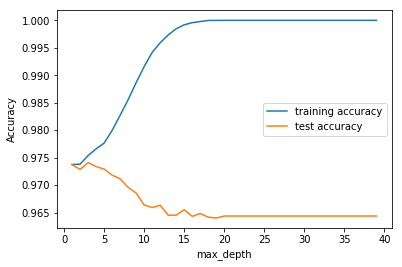

In [413]:
scores = tree.cv_results_
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Hyperparameter Tuning - min_samples_leaf

In [414]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")

tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

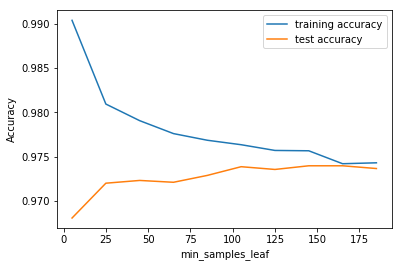

In [415]:
# plotting accuracies with min_samples_leaf
scores = tree.cv_results_

plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Hyperparameter Tuninng - min_samples_split

In [416]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

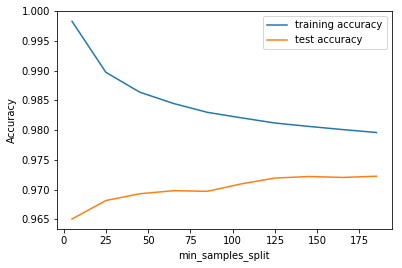

In [417]:
scores = tree.cv_results_
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Grid Search to find optimal parameters

In [816]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(1, 5, 1),
    'min_samples_leaf': range(75, 175, 25),
    'min_samples_split': range(50, 175, 25),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 5), 'min_samples_leaf': range(75, 175, 25), 'min_samples_split': range(50, 175, 25), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [817]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9745209735888141
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [838]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=3,
                                  min_samples_leaf=100,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [839]:
# accuracy score
clf_gini.score(X_test,y_test)

0.9740244049776489

In [840]:
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8029
           1       0.60      0.40      0.48       248

   micro avg       0.97      0.97      0.97      8277
   macro avg       0.79      0.69      0.73      8277
weighted avg       0.97      0.97      0.97      8277



In [841]:
# confusion matrix
print(confusion_matrix(y_test,y_pred))

[[7964   65]
 [ 150   98]]


#### Sensitivity score is ~ 0.4 based on hyperparamter tuning which was earlier 0.09 withouth hyperparameter tuning
#### However, this is not as good as with Logistic Regression where we got the Sensitivity score as ~ 0.83
#### Now testing with Random Forest

### Random Forest Algorithm - On Original Dataset not on PCA

In [424]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [425]:
# Making predictions
predictions = rfc.predict(X_test)

In [426]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8029
           1       0.68      0.22      0.33       248

   micro avg       0.97      0.97      0.97      8277
   macro avg       0.83      0.61      0.66      8277
weighted avg       0.97      0.97      0.97      8277



In [427]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[8003   26]
 [ 193   55]]


In [428]:
print(accuracy_score(y_test,predictions))

0.9735411380935122


#### Sensitivity is around 0.22 (i.e. 55 / (55+193))
#### Need Hyperparameter tuning

### Hyperparamter Tuning - max_depth

In [429]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

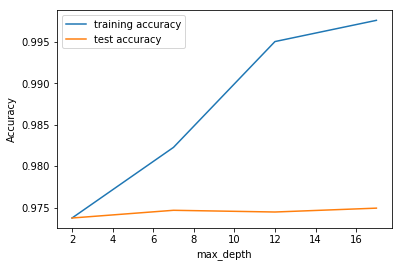

In [430]:
scores = rf.cv_results_
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

It can be seen that as we increase the value of max_depth, train scores increase and test scores almost remain constant

### Hyperparamter Tuning - n_estimators

In [431]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(100, 1500, 400)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

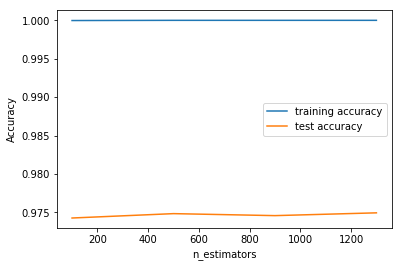

In [432]:
scores = rf.cv_results_

# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Hyperparamter Tuning - max_features

In [433]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [4, 8, 14, 20, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

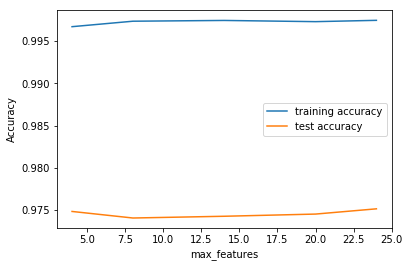

In [434]:
scores = rf.cv_results_

# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Hyperparamter Tuning - min_samples_leaf

In [435]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(100, 400, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

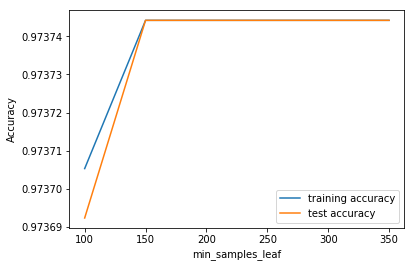

In [436]:
scores = rf.cv_results_
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Hyperparamter Tuning - min_samples_split

In [437]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(200, 500, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

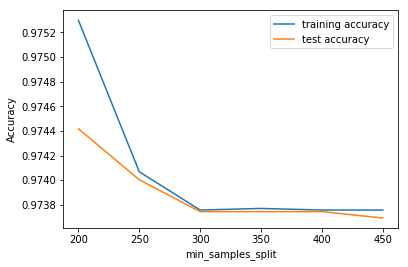

In [438]:
scores  = rf.cv_results_
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Grid Search to Find Optimal Paramters

In [859]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [25,50],
    'min_samples_leaf': range(100, 500, 200),
    'min_samples_split': range(100, 500, 200),
    'n_estimators': [50, 100], 
    'max_features': [20, 35, 50]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [860]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [25, 50], 'min_samples_leaf': range(100, 500, 200), 'min_samples_split': range(100, 500, 200), 'n_estimators': [50, 100], 'max_features': [20, 35, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [861]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.9742102537545313 using {'max_depth': 25, 'max_features': 50, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 50}


In [891]:
rfc = RandomForestClassifier(max_depth=25,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=150,
                             n_estimators=100)

In [892]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=150, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [893]:
# predict
predictions = rfc.predict(X_test)

In [894]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8029
           1       0.71      0.23      0.35       248

   micro avg       0.97      0.97      0.97      8277
   macro avg       0.84      0.61      0.67      8277
weighted avg       0.97      0.97      0.97      8277



In [895]:
print(confusion_matrix(y_test,predictions))

[[8006   23]
 [ 191   57]]


#### Sensitivity is 0 if we strictly follow the recommended values by the algorithm
#### However, on significantly increasing the max_features beyond the recommended value to ~50 we see that the Sensitivity has increased to ~0.23 (=57/(57+191))

# Identifying the key predictor variables

This will be done by using Logistic Regression on the original dataset and not on the PCA dataset

In [896]:
logreg = LogisticRegression()
rfe_var = RFE(logreg, 30)             # running RFE with 30 variables as output
rfe_var = rfe_var.fit(X_train, y_train)
list(zip(X_train.columns, rfe_var.support_, rfe_var.ranking_))

[('mobile_number', True, 1),
 ('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', True, 1),
 ('onnet_mou_6', False, 58),
 ('onnet_mou_7', False, 36),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 19),
 ('offnet_mou_7', False, 5),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 63),
 ('roam_ic_mou_7', False, 49),
 ('roam_ic_mou_8', False, 47),
 ('roam_og_mou_6', False, 50),
 ('roam_og_mou_7', False, 44),
 ('roam_og_mou_8', False, 43),
 ('loc_og_t2t_mou_6', False, 26),
 ('loc_og_t2t_mou_7', False, 22),
 ('loc_og_t2t_mou_8', False, 21),
 ('loc_og_t2m_mou_6', False, 4),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 70),
 ('loc_og_t2f_mou_7', False, 67),
 ('loc_og_t2f_mou_8', False, 68),
 ('loc_og_t2c_mou_6', False, 105),
 ('loc_og_t2c_mou_7', False, 102),
 ('loc_og_t2c_mou_8', False, 93),
 ('loc_og_mou_6', True, 1),
 ('loc_og_mou_7', True, 1),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 23),
 ('std_og_t2t_mou_7', Fa

In [897]:
rfe_var_retained_col = X_train.columns[rfe_var.support_]

In [898]:
len(rfe_var_retained_col)

30

In [899]:
X_train[rfe_var_retained_col].head(5)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_8,offnet_mou_8,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_8,total_og_mou_7,total_og_mou_8,loc_ic_t2m_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,aon,aug_vbc_3g,jul_vbc_3g
95277,7001571766,584.242,376.520,1391.753,412.63,140.59,60.33,123.89,399.86,498.38,553.23,0.00,499.49,641.06,116.41,274.09,123.44,259.49,275.06,124.06,299.63,672,453,1515,1255.15,869.66,787.02,2420,770.11,741.06
32145,7000472995,307.594,113.451,1196.164,293.66,379.64,32.09,335.24,64.48,106.73,644.86,28.44,107.68,677.54,561.46,1238.19,333.96,860.01,1238.53,334.74,867.13,356,156,1384,1173.05,1843.84,1909.58,671,1217.41,1313.68
26368,7000468482,274.221,679.791,95.668,8.68,88.01,297.86,79.61,67.49,327.49,81.18,15.51,1029.36,96.69,23.43,27.49,69.49,27.39,71.46,123.44,39.43,330,770,90,0.00,0.00,0.00,275,0.00,0.00
70009,7002221596,1193.323,622.526,823.951,53.18,382.18,77.81,50.61,224.28,134.93,96.11,328.48,1434.58,451.28,63.84,138.63,111.74,95.89,247.28,248.33,178.51,1346,660,962,0.00,0.00,1294.87,495,0.00,0.00
80227,7001612819,584.673,623.715,572.494,279.98,735.11,353.99,562.31,380.84,558.49,724.89,290.19,1050.11,1015.09,221.73,174.34,230.79,294.28,186.68,233.93,304.13,679,734,675,0.00,717.21,0.00,362,970.20,330.91


In [900]:
X_train_sm = sm.add_constant(X_train[rfe_var_retained_col])
logm_var = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res_var = logm_var.fit()
res_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19280
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1646.2
Date:                Sun, 03 Nov 2019   Deviance:                       3292.3
Time:                        11:20:19   Pearson chi2:                 6.89e+05
No. Iterations:                    10   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -467.0933    489.688     -0.954      0.340   -1426.864     492.678
mobile_number     6.635e-08   6.99e-08      0.949      0.343   -7.07e-08    2.03e-07
arpu_6               0.0008      0.000      2.781      0.005       0.000       0.001
arpu_7               0.0004      0.000      1.104      0.270      -0.000       0.001
arpu_8              -0.0003      0.000     -0.660      0.509      -0.001       0.001
onnet_mou_8          0.0025      0.000      6.424      0.000       0.002       0.003
offnet_mou_8         0.0023      0.000      6.029      0.000       0.002       0.003
loc_og_t2m_mou_7    -0.0014      0.001     -1.287      0.198      -0.003       0.001
loc_og_t2m_mou_8    -0.0005      0.002     -0.331      0.741      -0.004       0.003
loc_og_mou_6     -1.279e-05      0.000     -0.037      0.970      -0.001       0.001
loc_og_mou_7        -0.0007      0.001     -0.862      0.388      -0.002       0.001
loc_og_mou_8         0.0234      0.006      3.632      0.000       0.011       0.036
std_og_mou_8         0.0234      0.006      3.685      0.000       0.011       0.036
total_og_mou_7       0.0003      0.000      2.635      0.008    7.59e-05       0.001
total_og_mou_8      -0.0259      0.006     -4.101      0.000      -0.038      -0.014
loc_ic_t2m_mou_8    -0.0040      0.004     -1.136      0.256      -0.011       0.003
loc_ic_mou_6        -0.0009      0.001     -1.378      0.168      -0.002       0.000
loc_ic_mou_7         0.0005      0.001      0.475      0.635      -0.001       0.002
loc_ic_mou_8        -0.0070      0.003     -2.434      0.015      -0.013      -0.001
total_ic_mou_6       0.0014      0.001      2.772      0.006       0.000       0.002
total_ic_mou_7    2.987e-05      0.001      0.049      0.961      -0.001       0.001
total_ic_mou_8      -0.0035      0.001     -3.096      0.002      -0.006      -0.001
total_rech_amt_6     0.0002      0.000      0.923      0.356      -0.000       0.001
total_rech_amt_7     0.0004      0.000      1.295      0.195      -0.000       0.001
total_rech_amt_8    -0.0013      0.000     -3.696      0.000      -0.002      -0.001
vol_3g_mb_6      -5.301e-05      0.000     -0.484      0.628      -0.000       0.000
vol_3g_mb_7      -3.305e-05      0.000     -0.241      0.810      -0.000       0.000
vol_3g_mb_8         -0.0002      0.000     -1.331      0.183      -0.001       0.000
aon               -2.91e-05      7e-05     -0.416      0.678      -0.000       0.000
aug_vbc_3g          -0.0009      0.000     -1.976      0.048      -0.002   -7.51e-06
jul_vbc_3g          -0.0008      0.000     -2.285      0.022      -0.001      -0.000
====================================================================================
"""

In [901]:
vif_var = pd.DataFrame()
vif_var['Features'] = X_train[rfe_var_retained_col].columns
vif_var['VIF'] = [variance_inflation_factor(X_train[rfe_var_retained_col].values, i) for i in range(X_train[rfe_var_retained_col].shape[1])]
vif_var['VIF'] = round(vif_var['VIF'], 2)
vif_var = vif_var.sort_values(by = "VIF", ascending = False)
vif_var

,Features,VIF
13,total_og_mou_8,264.95
11,std_og_mou_8,189.50
10,loc_og_mou_8,82.67
5,offnet_mou_8,25.76
4,onnet_mou_8,24.80
16,loc_ic_mou_7,18.33
17,loc_ic_mou_8,16.71
19,total_ic_mou_7,16.33
15,loc_ic_mou_6,14.05
18,total_ic_mou_6,13.09


As the VIF is high for so many attributes it seems that there is high correlation between many of them

Below are the variables that may need to be dropped based on VIF values

total_og_mou_8, 
std_og_mou_8,
loc_og_mou_8,
offnet_mou_8,
onnet_mou_8,
loc_ic_mou_7,
loc_ic_mou_8,
total_ic_mou_7,
loc_ic_mou_6,	
total_ic_mou_6,
total_ic_mou_8,
arpu_8,
arpu_7,
total_rech_amt_8,
loc_og_mou_7,
total_rech_amt_7,
arpu_6,
total_rech_amt_6,
loc_og_t2m_mou_8,
loc_og_t2m_mou_7,
total_og_mou_7,
mobile_number,

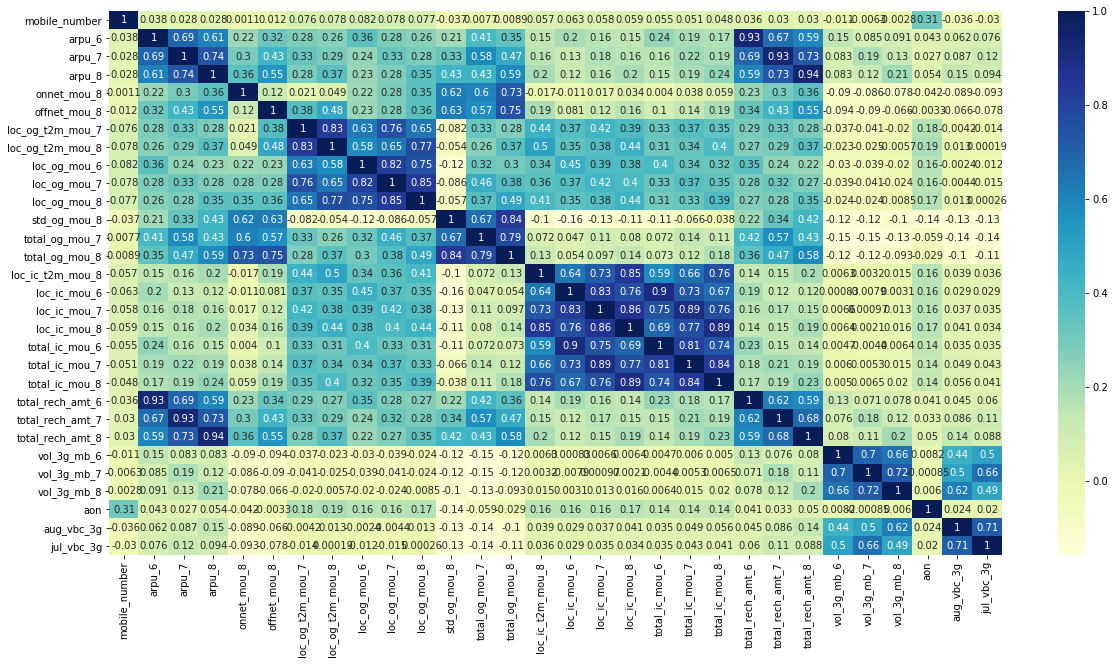

In [902]:
plt.figure(figsize = (20,10))
sns.heatmap(X_train[rfe_var_retained_col].corr(), annot = True, cmap="YlGnBu")
plt.show()

In [907]:
rfe_var_retained_col3 = ['total_og_mou_7','loc_og_mou_6','loc_ic_t2m_mou_8','vol_3g_mb_7','vol_3g_mb_8','jul_vbc_3g','aug_vbc_3g','vol_3g_mb_6','aon']

In [908]:
X_train_sm3 = sm.add_constant(X_train[rfe_var_retained_col3])
logm_var3 = sm.GLM(y_train,X_train_sm3, family = sm.families.Binomial())
res_var3 = logm_var3.fit()
res_var3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19300
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1857.0
Date:                Sun, 03 Nov 2019   Deviance:                       3713.9
Time:                        12:15:13   Pearson chi2:                 1.44e+06
No. Iterations:                    10   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.1538      0.094    -23.026      0.000      -2.337      -1.971
total_og_mou_7       0.0003   4.95e-05      6.189      0.000       0.000       0.000
loc_og_mou_6     -8.736e-05      0.000     -0.538      0.591      -0.000       0.000
loc_ic_t2m_mou_8    -0.0291      0.002    -16.761      0.000      -0.033      -0.026
vol_3g_mb_7       4.626e-05      0.000      0.345      0.730      -0.000       0.000
vol_3g_mb_8         -0.0006      0.000     -3.106      0.002      -0.001      -0.000
jul_vbc_3g          -0.0004      0.000     -1.160      0.246      -0.001       0.000
aug_vbc_3g          -0.0014      0.001     -2.744      0.006      -0.002      -0.000
vol_3g_mb_6       8.471e-05   9.57e-05      0.885      0.376      -0.000       0.000
aon               2.934e-05   6.33e-05      0.463      0.643   -9.48e-05       0.000
====================================================================================
"""

In [909]:
vif_var3 = pd.DataFrame()
vif_var3['Features'] = X_train[rfe_var_retained_col3].columns
vif_var3['VIF'] = [variance_inflation_factor(X_train[rfe_var_retained_col3].values, i) for i in range(X_train[rfe_var_retained_col3].shape[1])]
vif_var3['VIF'] = round(vif_var3['VIF'], 2)
vif_var3 = vif_var3.sort_values(by = "VIF", ascending = False)
vif_var3

,Features,VIF
3,vol_3g_mb_7,4.02
4,vol_3g_mb_8,3.62
5,jul_vbc_3g,3.50
6,aug_vbc_3g,3.26
7,vol_3g_mb_6,2.50
1,loc_og_mou_6,1.88
8,aon,1.79
2,loc_ic_t2m_mou_8,1.68
0,total_og_mou_7,1.64


VIF values are all <5 but based on p-value need to drop further variables

In [910]:
rfe_var_retained_col5 = ['total_og_mou_7',
                         'loc_ic_t2m_mou_8',
                         'vol_3g_mb_8',
                         'aug_vbc_3g']

In [911]:
X_train_sm5 = sm.add_constant(X_train[rfe_var_retained_col5])
logm_var5 = sm.GLM(y_train,X_train_sm5, family = sm.families.Binomial())
res_var5 = logm_var5.fit()
res_var5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19310
Model:                            GLM   Df Residuals:                    19305
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1858.2
Date:                Sun, 03 Nov 2019   Deviance:                       3716.4
Time:                        13:46:47   Pearson chi2:                 1.43e+06
No. Iterations:                    10   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.1296      0.074    -28.633      0.000      -2.275      -1.984
total_og_mou_7       0.0003   4.78e-05      6.219      0.000       0.000       0.000
loc_ic_t2m_mou_8    -0.0291      0.002    -17.213      0.000      -0.032      -0.026
vol_3g_mb_8         -0.0005      0.000     -3.111      0.002      -0.001      -0.000
aug_vbc_3g          -0.0016      0.000     -3.779      0.000      -0.003      -0.001
====================================================================================
"""

In [912]:
vif_var5 = pd.DataFrame()
vif_var5['Features'] = X_train[rfe_var_retained_col5].columns
vif_var5['VIF'] = [variance_inflation_factor(X_train[rfe_var_retained_col5].values, i) for i in range(X_train[rfe_var_retained_col5].shape[1])]
vif_var5['VIF'] = round(vif_var5['VIF'], 2)
vif_var5 = vif_var5.sort_values(by = "VIF", ascending = False)
vif_var5

,Features,VIF
3,aug_vbc_3g,1.87
2,vol_3g_mb_8,1.85
1,loc_ic_t2m_mou_8,1.29
0,total_og_mou_7,1.24


All the VIF values are now <5 and p-values are << 0.05. Therefore, all are in acceptable range

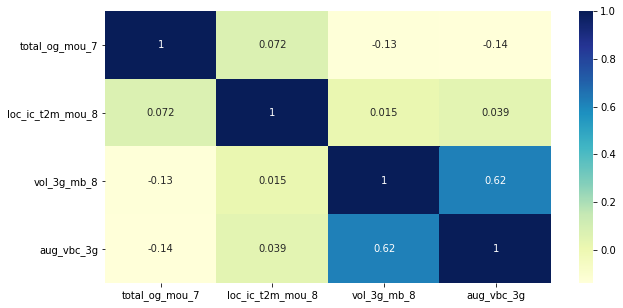

In [914]:
plt.figure(figsize = (10,5))
sns.heatmap(X_train[rfe_var_retained_col5].corr(), annot = True, cmap="YlGnBu")
plt.show()

In [916]:
# Therefore, the final shortlisted variables would be 
rfe_var_retained_col5

['total_og_mou_7', 'loc_ic_t2m_mou_8', 'vol_3g_mb_8', 'aug_vbc_3g']

- total_og_mou_7: Total outgoing calls; minutes of usages voice calls;7th Month
- loc_ic_t2m_mou_8: Local calls - within same telecom circle; Incoming calls; Operator T to other operator mobile; Minutes of usage - voice calls; 8th Month
- vol_3g_mb_8: Mobile internet usage volume (in MB); 3g; data in mb; 8th Month
- aug_vbc_3g: Volume based cost - when no specific scheme is not purchased and paid as per usage; 8th Month

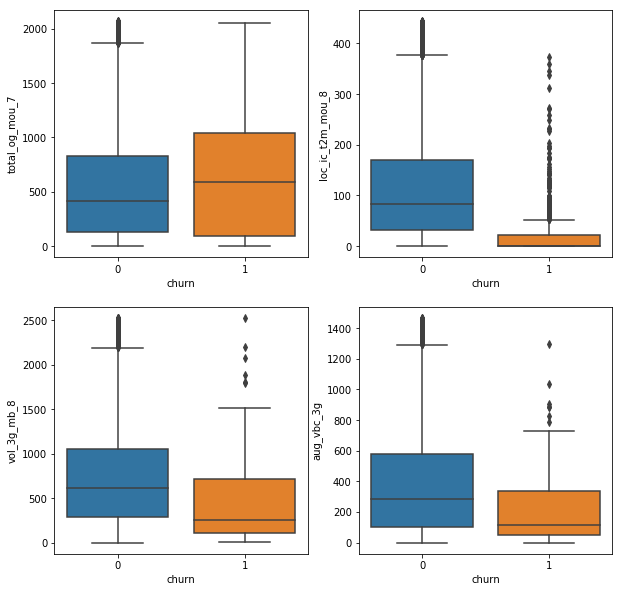

In [952]:
# Plotting to see how each of the above identified variables varies for 0/1 of Churn variable
# For each of the variables the upper end outliers are removed

plt.figure(figsize=[10,10])

plt.subplot(2,2,1)
q1 = tchurn_hv_df['total_og_mou_7'].quantile(0.25)
q3 = tchurn_hv_df['total_og_mou_7'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['total_og_mou_7'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'total_og_mou_7', data = temp)

plt.subplot(2,2,2)
q1 = tchurn_hv_df['loc_ic_t2m_mou_8'].quantile(0.25)
q3 = tchurn_hv_df['loc_ic_t2m_mou_8'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['loc_ic_t2m_mou_8'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'loc_ic_t2m_mou_8', data = temp)

plt.subplot(2,2,3)
temp = tchurn_hv_df[tchurn_hv_df['vol_3g_mb_8'] !=0]
q1 = temp['vol_3g_mb_8'].quantile(0.25)
q3 = temp['vol_3g_mb_8'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['vol_3g_mb_8'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'vol_3g_mb_8', data = temp)

plt.subplot(2,2,4)
temp = tchurn_hv_df[tchurn_hv_df['aug_vbc_3g'] != 0]
q1 = temp['aug_vbc_3g'].quantile(0.25)
q3 = temp['aug_vbc_3g'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['aug_vbc_3g'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'aug_vbc_3g', data = temp)

plt.show()

By seeing the above the following could be inferred about churn
- Total outgoing calls in minutes of usages of voice calls for the 7th Month was higher for customers who churned than for those who didnt --> Need to analyze the behavior of the Total outgoing calls for months 6th and 8th to see the trend
- Incoming Local voice calls - within same telecom circle between Operator T to other operator mobile in terms of Minutes of usage for 8th Month was lower for customers who churned than for those who didnt churn --> Need to analyze the behavior of the Incoming local voice calls between Operator and other operators' mobile phone
- Average mobile internet (3g) usage by volumne (in MB) for 8th Month was on average lower for those who churned than those who didnt churn
- Volume based cost - when no specific scheme is not purchased and paid as per usage; the volume based cost for 8th Month of those who churned was lower than those who didnt churn

Text(0.5, 1.0, '8th Month')

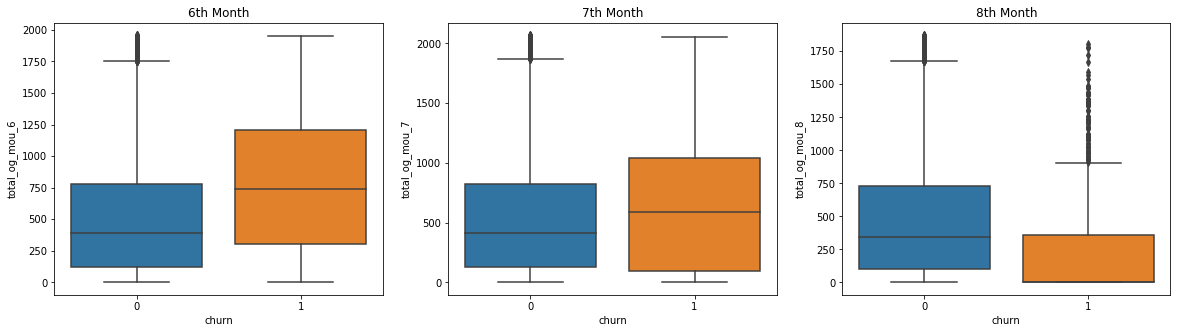

In [965]:
# Observing the trend of total outgoing voice calls usage (in minutes) for months 6,7, and 8
plt.figure(figsize=[20,5])

plt.subplot(1,3,1)
q1 = tchurn_hv_df['total_og_mou_6'].quantile(0.25)
q3 = tchurn_hv_df['total_og_mou_6'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['total_og_mou_6'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'total_og_mou_6', data = temp)
plt.title('6th Month')

plt.subplot(1,3,2)
q1 = tchurn_hv_df['total_og_mou_7'].quantile(0.25)
q3 = tchurn_hv_df['total_og_mou_7'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['total_og_mou_7'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'total_og_mou_7', data = temp)
plt.title('7th Month')

plt.subplot(1,3,3)
q1 = tchurn_hv_df['total_og_mou_8'].quantile(0.25)
q3 = tchurn_hv_df['total_og_mou_8'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['total_og_mou_8'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'total_og_mou_8', data = temp)
plt.title('8th Month')

#### Seeing the above graph it is very clear that Total outgoing calls in minutes of usages of voice calls keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same

Text(0.5, 1.0, '8th Month')

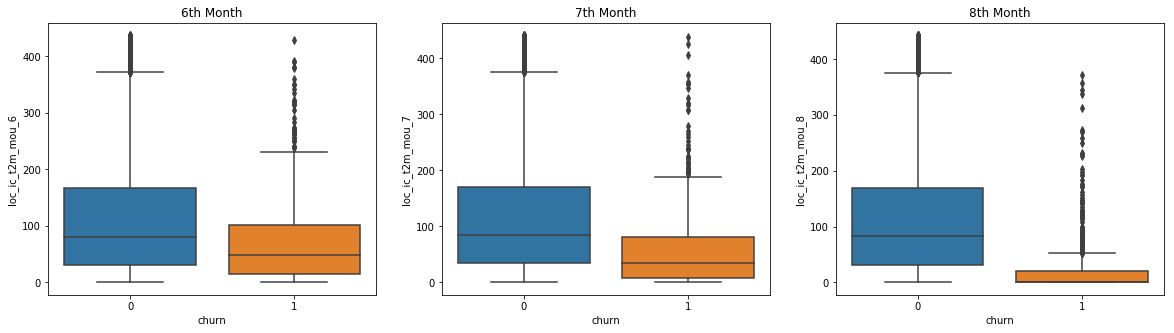

In [966]:
# Observing the trend of local incoming voice calls usage (in minutes) from other operators mobile network for months 6,7, and 8
plt.figure(figsize=[20,5])

plt.subplot(1,3,1)
q1 = tchurn_hv_df['loc_ic_t2m_mou_6'].quantile(0.25)
q3 = tchurn_hv_df['loc_ic_t2m_mou_6'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['loc_ic_t2m_mou_6'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'loc_ic_t2m_mou_6', data = temp)
plt.title('6th Month')

plt.subplot(1,3,2)
q1 = tchurn_hv_df['loc_ic_t2m_mou_7'].quantile(0.25)
q3 = tchurn_hv_df['loc_ic_t2m_mou_7'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['loc_ic_t2m_mou_7'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'loc_ic_t2m_mou_7', data = temp)
plt.title('7th Month')

plt.subplot(1,3,3)
q1 = tchurn_hv_df['loc_ic_t2m_mou_8'].quantile(0.25)
q3 = tchurn_hv_df['loc_ic_t2m_mou_8'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = tchurn_hv_df[tchurn_hv_df['loc_ic_t2m_mou_8'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'loc_ic_t2m_mou_8', data = temp)
plt.title('8th Month')

#### Seeing the above graph it is very clear that the Local incoming calls in minutes of usages of voice calls from other operators' mobile networks keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same

Text(0.5, 1.0, '8th Month')

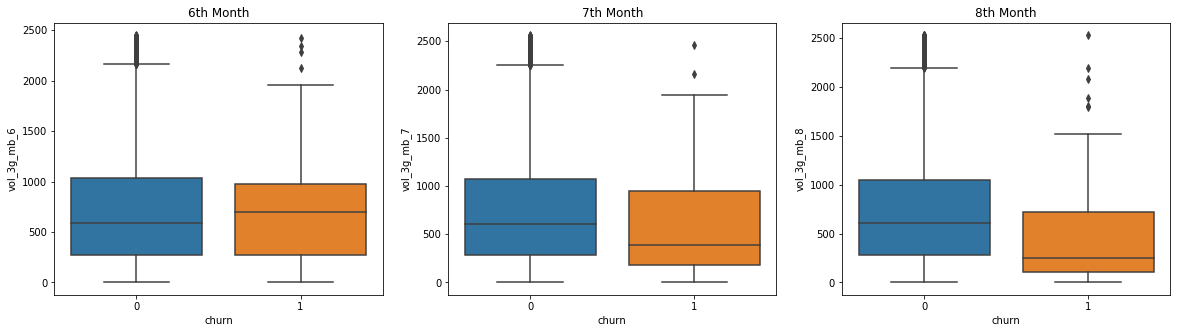

In [967]:
# Observing the trend of Average mobile internet (3g) usage by volumne (in MB) for months 6,7, and 8
plt.figure(figsize=[20,5])

plt.subplot(1,3,1)
temp = tchurn_hv_df[tchurn_hv_df['vol_3g_mb_6'] !=0]
q1 = temp['vol_3g_mb_6'].quantile(0.25)
q3 = temp['vol_3g_mb_6'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['vol_3g_mb_6'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'vol_3g_mb_6', data = temp)
plt.title('6th Month')

plt.subplot(1,3,2)
temp = tchurn_hv_df[tchurn_hv_df['vol_3g_mb_7'] !=0]
q1 = temp['vol_3g_mb_7'].quantile(0.25)
q3 = temp['vol_3g_mb_7'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['vol_3g_mb_7'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'vol_3g_mb_7', data = temp)
plt.title('7th Month')

plt.subplot(1,3,3)
temp = tchurn_hv_df[tchurn_hv_df['vol_3g_mb_8'] !=0]
q1 = temp['vol_3g_mb_8'].quantile(0.25)
q3 = temp['vol_3g_mb_8'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['vol_3g_mb_8'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'vol_3g_mb_8', data = temp)
plt.title('8th Month')

#### Seeing the above graph it is very clear that the Average mobile internet (3g) usage by volumne (in MB) keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same

Text(0.5, 1.0, '8th Month')

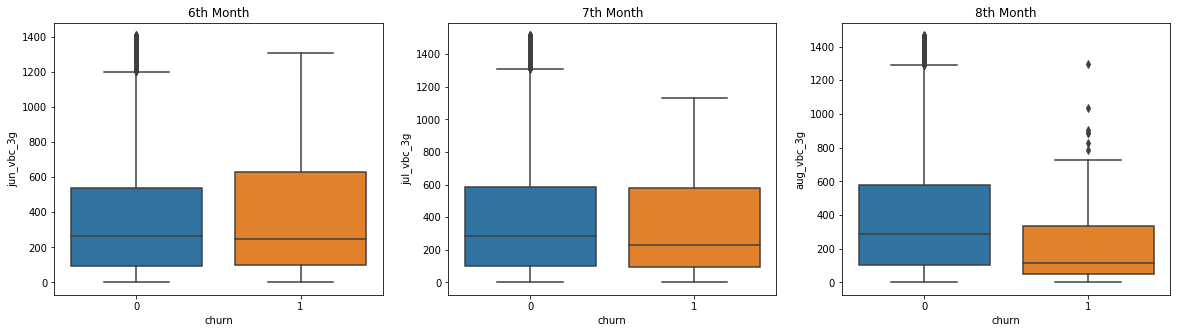

In [968]:
# Observing the trend of total outgoing voice calls usage (in minutes) for months 6,7, and 8
plt.figure(figsize=[20,5])

plt.subplot(1,3,1)
temp = tchurn_hv_df[tchurn_hv_df['jun_vbc_3g'] != 0]
q1 = temp['jun_vbc_3g'].quantile(0.25)
q3 = temp['jun_vbc_3g'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['jun_vbc_3g'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'jun_vbc_3g', data = temp)
plt.title('6th Month')

plt.subplot(1,3,2)
temp = tchurn_hv_df[tchurn_hv_df['jul_vbc_3g'] != 0]
q1 = temp['jul_vbc_3g'].quantile(0.25)
q3 = temp['jul_vbc_3g'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['jul_vbc_3g'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'jul_vbc_3g', data = temp)
plt.title('7th Month')

plt.subplot(1,3,3)
temp = tchurn_hv_df[tchurn_hv_df['aug_vbc_3g'] != 0]
q1 = temp['aug_vbc_3g'].quantile(0.25)
q3 = temp['aug_vbc_3g'].quantile(0.75)
iqr = q3-q1 #Interquartile range
inner_fence_high = q3+1.5*iqr
temp = temp[temp['aug_vbc_3g'] <= inner_fence_high]
sns.boxplot(x = 'churn', y = 'aug_vbc_3g', data = temp)
plt.title('8th Month')

#### Seeing the above graph it is very clear that the volume based cost keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same

# Summary - Results, Findings and Inferences

1. Following were the learning algorithms used
    - Logistic Regression
    - Decision Tree
    - Random Forest
- Following were the type of data set combinations used
    - With Dimensionalty Reduction (i.e. PCA)
    - Without Dimensionalty Reduction (i.e. without PCA)
- Also, Following were the Tuning made
    - With Hyperparameter Tuning
    - Without Hyperparameter Tuning
2. The summary of the models built using permutations of the above learning algorithms, dataset type and Tuning types is displayed below. It show the Confusion Matrix output of each Model and the Sensitivity score
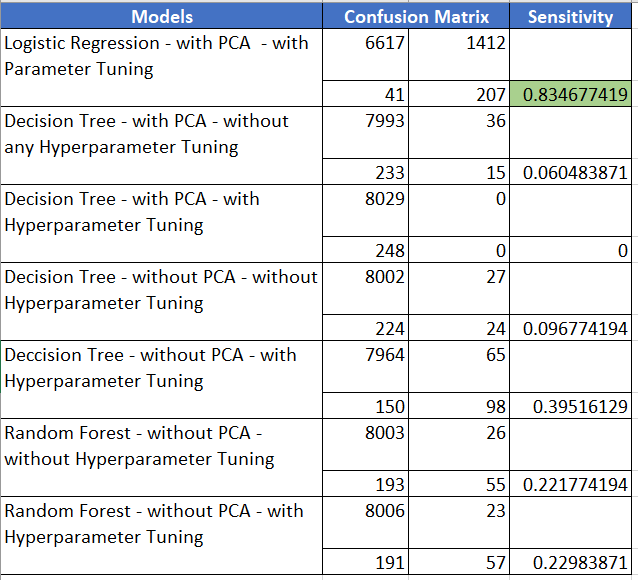



3. It could be easily inferred that the best model derived was using Logistic Regression on dataset reduced dimensionally using PCA
4. The key parameter to measure here was Sensitivity as we had to measure the customers who churned correctly not predicting those who havent churned
5. The best model derived had Sensitivity ~0.83 and Accuracy ~0.84 which was reasonable. On further trying to improve the Sensitivity the Accuracy of the model was taking a hit. Therefore we reached an optimal level
6. A separate model was built using Logistic Regression to identify the predictor variables. Based on that following key variables were identified
    - Total outgoing calls in minutes of usages of voice calls for the 7th Month
    - Incoming Local voice calls - within same telecom circle between Operator T to other operator mobile in terms of Minutes of usage for 8th Month
    - Average mobile internet (3g) usage by volumne (in MB) for 8th Month
    - Volume based cost - when no specific scheme is not purchased and paid as per usage; the volume based cost for 8th Month
7. On further analysing each of these 4 variables across the 3 months i.e. month 6,7,8 both the Good Phase months and the Action Phase month the following could easily be derived
    - Total outgoing calls in minutes of usages of voice calls keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same
    - The Local incoming calls in minutes of usages of voice calls from other operators' mobile networks keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same
    - The Average mobile internet (3g) usage by volumne (in MB) keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same
    - The volume based cost keeps on decreasing for churn customers, whereas for non-churn customers it broadly remains the same

# Recommended Strategies to manage Customer Churn

Based on the key predictor variables identified above following are some of the strategies that could be adopted by the telecom company to reduce the churn
1. If there is a drop in the total outgoing calls in the "Good Phase" i.e. between month 6 and 7 then provide some incentives to the customer in the "Action Phase" i.e. month 8 which could like some of the following 
    - Offering free outgoing calls say for a month.This will ensure that for the same balance the customer will stick for atleast a month now
    - Offer healthy Cashback amount on recharge for the 8th and 9th month together
    - Free data pack on recharge for month 8 and 9 together
2. As we are dealing with High Value Customers here, most of them should be able to pay for two months recharge together in advance in exchange of some good offers. Also, since acquiring a customer costs 5-10 times more than retaining an existing one, these offers shouldnt harm the company's financials much
3. Lowering of Outgoing Calls could also suggest Network Congestion / Frequent call drops in a paricular area etc. i.e. some back end network related issues. The Telecom Company should analyze if all the churn customers belong to a particular micro-region of a City and if yes, then they will have to look at ways to lower the network issues. If it means like adding more towers etc. which could take more time, then some offers like mentioned above could help to engage the customer in the interim
4. As on all the parameters the trends are going down i.e. the total outgoing voice valls, local incoming from mobile, average mobile internet usage by volume it appears that the customers are largely not using the SIM card or may have placed it in the secondary slot of a dual SIM. Therefore, this could only mean that the customers are not happy with the service provided by the telecom company or a competitor is offering better services / offers. However, given the study decline noticed, it appears that the customers are not happy with the current services provided by the telecom company. Therefore, the company needs to 
    - Offer some incentives as highlighted in point #1 above to keep the customers engaged and avoid them churning out
    - Improve its Network Capabilities to avoid call drops and data connectivity issues
    - Improve its Call Center Operations to ensure that the customer reported complaints are resolved as soon as possible